<a href="https://colab.research.google.com/github/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/blob/main/MMAI869_Pump_It_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MMAI 869, Smith School of Business at Queens University
###Team Broadview Project, Pump it Up: Data Mining the Water Table

###Import Libraries

In [2141]:
import numpy as np  
import pandas as pd  
import datetime as dt

# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score, plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report


from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.utils import compute_class_weight
from sklearn.metrics import plot_roc_curve


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


### Check Allocated System Specs by Google Colab

In [2142]:
from psutil import *

cpu_count()

2

In [2143]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [2144]:
!df -h / |awk '{print $4}'

Avail
86G


In [2145]:
!free -h  --si | awk '/Mem:/{print $2}'

13G


In [2146]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2147]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



###Helper Function

In [2148]:
#method to print better looking plots

def pretty_importances_plot(importances, feature_name, fig_size = (10, 7), xlabel = '', ylabel = '', horizontal_label = None, n_elements=None):
    '''
    This function plots a better looking importances-plot
    
    importances: Occurences of feature_name
    feature_name: unique feature_name
    fig_size: size of plot
    xlabel: xlabel
    ylabel: ylabel
    horizontal_label: Bigger label at the top-left
    n_elements: number of elements to display
    '''
    
    # This code has been borrowed from:
    # https://scentellegher.github.io/visualization/2018/10/10/beautiful-bar-plots-matplotlib.html
    # Credits to SIMONE CENTELLEGHER

    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'

    # percentages = pd.Series(data= list(map(operator.itemgetter(1), word_importances_title_entity)),
    #                       index = list(map(operator.itemgetter(0), word_importances_title_entity)))
    
    if not n_elements:
        n_elements = len(importances)
    
    percentages = pd.Series(
        data = importances[:n_elements],
        index = feature_name[:n_elements]
    )

    df = pd.DataFrame({'percentage' : percentages})
    df = df.sort_values(by='percentage')

    # we first need a numeric placeholder for the y axis
    my_range=list(range(1,len(df.index)+1))

    #fig, ax = plt.subplots(figsize=(5,3.5)) ######################
    fig, ax = plt.subplots(figsize=fig_size)


    # create for each expense type an horizontal line that starts at x = 0 with the length 
    # represented by the specific expense percentage value.
    plt.hlines(y=my_range, xmin=0, xmax=df['percentage'], color='#007ACC', alpha=0.2, linewidth=5)

    # create for each expense type a dot at the level of the expense percentage value
    plt.plot(df['percentage'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

    # set labels
    ax.set_xlabel(xlabel, fontsize=15, fontweight='black', color = '#333F4B')
    ax.set_ylabel(ylabel)
    
     # set axis
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.yticks(my_range, df.index)

    # add an horizonal label for the y axis
    if horizontal_label:
        fig.text(-0.23, 0.96, horizontal_label, fontsize=15, fontweight='black', color = '#333F4B')

    # change the style of the axis spines
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)

    # set the spines position
    ax.spines['bottom'].set_position(('axes', -0.04))
    ax.spines['left'].set_position(('axes', 0.015))

#1. Loading the dataset from GitHub: [MMAI869-Pump-it-Up-Competition]

  Data is accessed from github: (https://github.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition)



In [2149]:
ulr_Training_Set_Values = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/Training_Set_Values.csv'
ulr_Training_Set_Labels = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/Training_Set_Labels.csv'
ulr_Test_Set_Values = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/Test_Set_Values.csv'
Training_Set_Values = pd.read_csv(ulr_Training_Set_Values)
Training_Set_Labels = pd.read_csv(ulr_Training_Set_Labels)
test = pd.read_csv(ulr_Test_Set_Values)
data = Training_Set_Values.merge(Training_Set_Labels, on='id', how='right')

In [2150]:
data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [2151]:
len(data)

59400

In [2152]:
# data.isnull().sum()

In [2153]:
# test.isnull().sum()

#2- Data Cleaning and Imputation

In [2154]:
# data.info()

##2.1- Numerical Features
Some of the numerical features are actally categorical, since they get only certain values relating to a specific region, such as:
1.   region_code
2.   district_code

We will consider these in categorical features. Also the year constructed is a date&Time feature.

In [2155]:
df_numerical_features = data.select_dtypes(exclude='object')
df_numerical_features.columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'construction_year'],
      dtype='object')

###2.1.1- amount_tsh
Total static head (amount water available to waterpoint)

https://inspectapedia.com/water/Well_Static_Head_Definition.php

The static head volume inside a water well tells us how much water is available to the pump after the well has rested, water has risen to its maximum height inside the well, and the pump is about to turn on.

* Depending on the unit of measurment for volume, some values might not make sense, we don't have the unit here
* We have 41639 values of zero, need to replace them with some representative number with assumption, i.e. mean of other values. I will consider only the values that are not occuring only once, just an auumption
* Need to remove outliers as well, lets decide which one is considered as outlier. Left them to be for now

In [2156]:
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html

data.amount_tsh.value_counts().sort_values(ascending=False)

0.00        41639
500.00       3102
50.00        2472
1000.00      1488
20.00        1463
            ...  
0.25            1
12.00           1
60000.00        1
306.00          1
59.00           1
Name: amount_tsh, Length: 98, dtype: int64

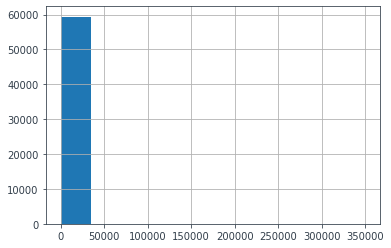

In [2157]:
data.amount_tsh.hist()

In [2158]:
# data[data['amount_tsh'].map(data['amount_tsh'].value_counts() > 1)]

In [2159]:
tsh_multiple_occurance_df = data.groupby('amount_tsh').filter(lambda x: len(x) > 1)
tsh_multiple_nonzero_occurance_df = tsh_multiple_occurance_df[tsh_multiple_occurance_df.amount_tsh>0]
tsh_multiple_nonzero_occurance_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
5,9944,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,Tajiri,0,Pangani,Moa/Mwereme,Tanga,4,8,Mkinga,Moa,1,True,GeoData Consultants Ltd,VWC,Zingibali,True,2009,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe,functional
11,50409,200.0,2013-02-18,Danida,1062,DANIDA,35.770258,-10.574175,Kwa Alid Nchimbi,0,Lake Nyasa,Ngondombwito,Ruvuma,10,5,Namtumbo,Msindo,250,True,GeoData Consultants Ltd,WUG,NaN,False,1987,swn 80,swn 80,handpump,wug,user-group,pay when scheme fails,on failure,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
16,48451,500.0,2011-07-04,Unicef,1703,DWE,34.642439,-9.106185,Kwa John Mtenzi,0,Rufiji,Kidudumo,Iringa,11,4,Njombe,Mdandu,35,True,GeoData Consultants Ltd,WUA,wanging'ombe water supply s,True,1978,gravity,gravity,gravity,wua,user-group,pay monthly,monthly,soft,good,dry,dry,river,river/lake,surface,communal standpipe,communal standpipe,non functional


In [2160]:
tsh_zero_value_df = tsh_multiple_occurance_df[tsh_multiple_occurance_df.amount_tsh==0]
zero_tsh_index = tsh_zero_value_df.id.tolist()
data.loc[data['id'].isin(zero_tsh_index), 'amount_tsh'] = round(tsh_multiple_nonzero_occurance_df.amount_tsh.mean())

In [2161]:
data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,984.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,984.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,984.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


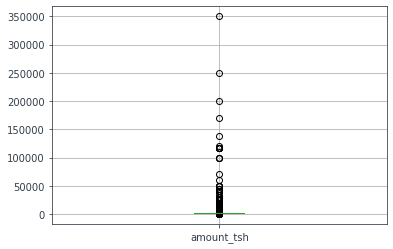

In [2162]:
boxplot = data.boxplot(column=['amount_tsh'])

* For the Na values, decided to use the most frequent value instead

###2.1.3- Coordinates: gps_height, longitude, latitude

In [2163]:
data.gps_height.value_counts()

 0       20438
-15         60
-16         55
-13         55
 1290       52
         ...  
 2378        1
-54          1
 2057        1
 2332        1
 2366        1
Name: gps_height, Length: 2428, dtype: int64

In [2164]:
data.longitude.value_counts()

0.000000     1812
37.375717       2
38.340501       2
39.086183       2
33.005032       2
             ... 
35.885754       1
36.626541       1
37.333530       1
38.970078       1
38.104048       1
Name: longitude, Length: 57516, dtype: int64

###2.1.4- num_private
num_private, This feature is mostly missing, so we will drop it from dataset. 98% of the num_private feature has value of zero, so we drop it from our dataset.

In [2165]:
data = data.drop(['num_private'], axis=1)
test = test.drop(['num_private'], axis=1)

###2.1.7- population
Population around the well

In [2166]:
data.population.value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
6330        1
5030        1
656         1
948         1
788         1
Name: population, Length: 1049, dtype: int64

##2.2- Categorical Features

Categorical features can have so many instances that happen only a few times or even once. This is not very informative for an ML model. 

This can lead to high cardinality.

We will create a new category for instances occuring "once"

Infrequent labels are so few, that it is hard to derive reliable information from them. But more importantly, infrequent labels tend to appear only on train set or only on the test set, leading to:

*   If only on the train set, they may cause over-fitting
*   If only on the test set, our machine learning model will not know how to score them

The identification of rare labels should be done using only the training set, and then propagated to the test set. Rare labels should be identified in the training set only. Thus, we will leave it for feature engineering stage.

https://github.com/solegalli/feature-engineering-for-machine-learning/blob/main/Section-06-Categorical-Encoding/06.10-Engineering-Rare-Categories.ipynb


In [2167]:
df_categorical_features = data.select_dtypes(include='object')
df_categorical_features.columns

Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group'],
      dtype='object')

In [2168]:
# df_categorical_features.isnull().sum()

###2.2.1- Categorical features, No 'Rare" Value Encoding Required:  basin, region, source_class





In [2169]:
data.basin.value_counts().sort_values(ascending=False)

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

Text(0, 0.5, 'Number of Occurance')

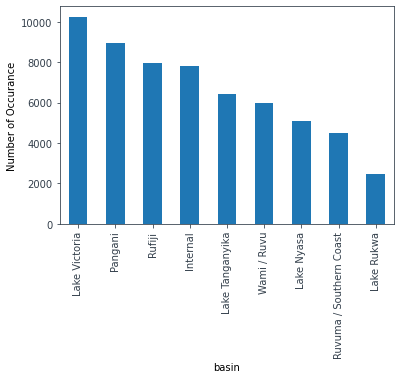

In [2170]:
data.basin.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('basin')
plt.ylabel('Number of Occurance')

In [2171]:
data.region.value_counts().sort_values(ascending=False)

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

Text(0, 0.5, 'Number of Occurance')

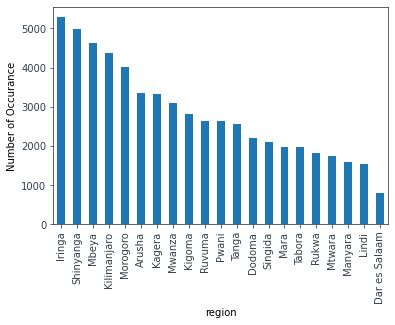

In [2172]:
data.region.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('region')
plt.ylabel('Number of Occurance')

In [2173]:
data.source_class.value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

Text(0, 0.5, 'Number of Occurance')

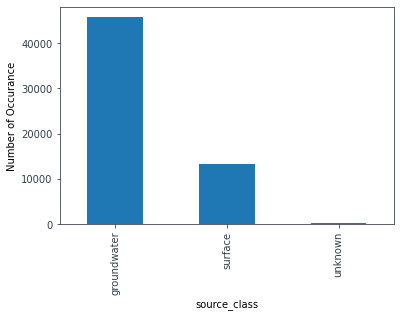

In [2174]:
data.source_class.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('source_class')
plt.ylabel('Number of Occurance')

###2.2.2- Categorical features, Features Might Need Cardinality Reduction. "Rare" Value Encoding Required

lga, ward, region_code, district_code, extraction_type, extraction_type_group, extraction_type_class, management, management_group, payment, payment_type, water_quality, quality_group, quantity, quantity_group, source, source_type, waterpoint_type, waterpoint_type_group


These features have no issue in terms of missing values, high cardinality might be an issue, will run rare value encoding with a threshold. We will encode them in feature engineering stage.

In [2175]:
data.lga.value_counts().sort_values(ascending=False)

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

In [2176]:
lga_once_occurance_df = data.groupby('lga').filter(lambda x: len(x) < 22)
# lga_once_occurance_df.head()
once_lga_index = lga_once_occurance_df.id.tolist()
print(len(once_lga_index))
# data.loc[data['id'].isin(once_lga_index), 'lga'] = "once"

22


Text(0, 0.5, 'Number of Occurance')

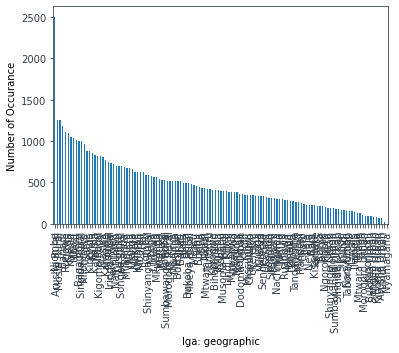

In [2177]:
data.lga.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('lga: geographic')
plt.ylabel('Number of Occurance')

In [2178]:
data.ward.value_counts().sort_values(ascending=False)

Igosi        307
Imalinyi     252
Siha Kati    232
Mdandu       231
Nduruma      217
            ... 
Kitete         1
Ukata          1
Sungwisi       1
Mawenzi        1
Kinungu        1
Name: ward, Length: 2092, dtype: int64

In [2179]:
ward_once_occurance_df = data.groupby('ward').filter(lambda x: len(x) < 2 )
# ward_once_occurance_df.head()
once_ward_index = ward_once_occurance_df.id.tolist()
print(len(once_ward_index))
# data.loc[data['id'].isin(once_ward_index), 'ward'] = "once"

30


In [2180]:
data.region_code.value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

Text(0, 0.5, 'Number of Occurance')

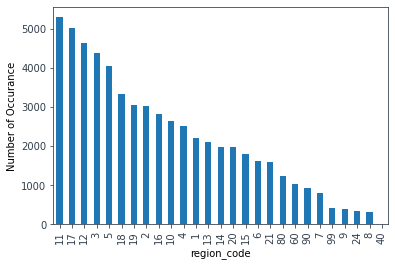

In [2181]:
data.region_code.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('region_code')
plt.ylabel('Number of Occurance')

In [2182]:
data.district_code.value_counts().sort_values(ascending=False)

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

Text(0, 0.5, 'Number of Occurance')

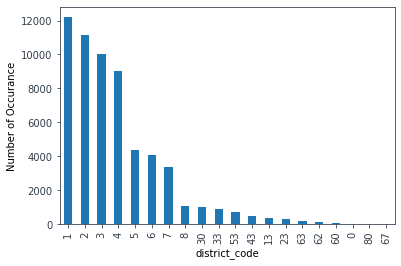

In [2183]:
data.district_code.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('district_code')
plt.ylabel('Number of Occurance')

In [2184]:
data.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

Text(0, 0.5, 'Number of Occurance')

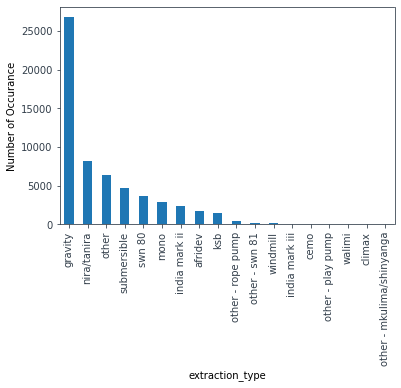

In [2185]:
data.extraction_type.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('extraction_type')
plt.ylabel('Number of Occurance')

In [2186]:
data.extraction_type_group.value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

Text(0, 0.5, 'Number of Occurance')

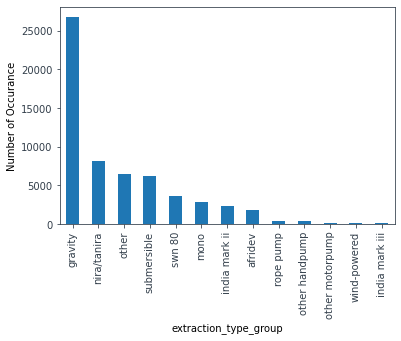

In [2187]:
data.extraction_type_group.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('extraction_type_group')
plt.ylabel('Number of Occurance')

In [2188]:
data.extraction_type_class.value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

Text(0, 0.5, 'Number of Occurance')

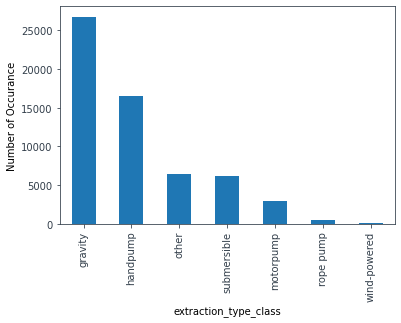

In [2189]:
data.extraction_type_class.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('extraction_type_class')
plt.ylabel('Number of Occurance')

In [2190]:
data.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

Text(0, 0.5, 'Number of Occurance')

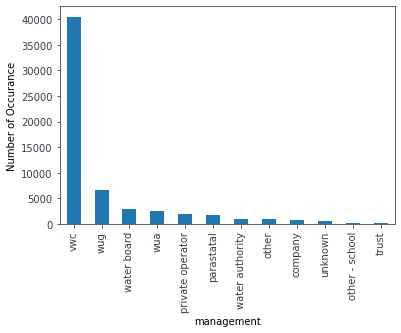

In [2191]:
data.management.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('management')
plt.ylabel('Number of Occurance')

In [2192]:
data.management_group.value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

Text(0, 0.5, 'Number of Occurance')

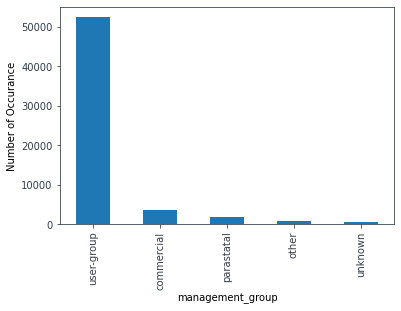

In [2193]:
data.management_group.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('management_group')
plt.ylabel('Number of Occurance')

In [2194]:
data.payment.value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

Text(0, 0.5, 'Number of Occurance')

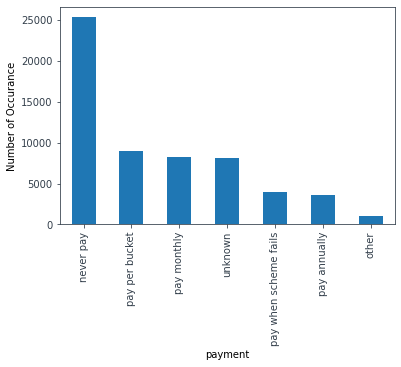

In [2195]:
data.payment.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('payment')
plt.ylabel('Number of Occurance')

In [2196]:
data.payment_type.value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

Text(0, 0.5, 'Number of Occurance')

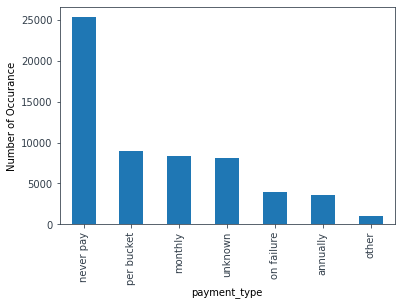

In [2197]:
data.payment_type.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('payment_type')
plt.ylabel('Number of Occurance')

In [2198]:
data.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

Text(0, 0.5, 'Number of Occurance')

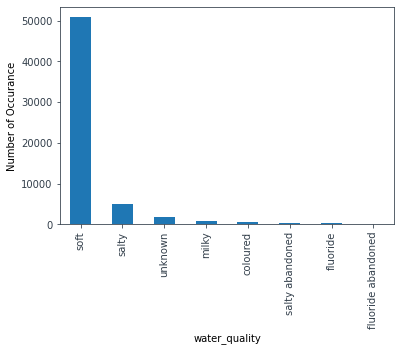

In [2199]:
data.water_quality.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('water_quality')
plt.ylabel('Number of Occurance')

In [2200]:
data.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

Text(0, 0.5, 'Number of Occurance')

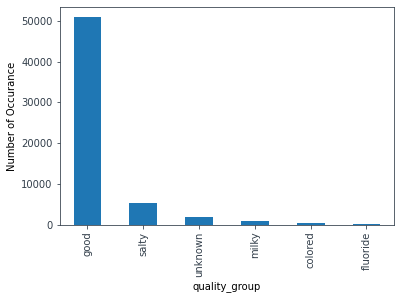

In [2201]:
data.quality_group.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('quality_group')
plt.ylabel('Number of Occurance')

In [2202]:
data.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

/usr/local/lib/python3.8/dist-packages/IPython/core/displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


Text(0, 0.5, 'Number of Occurance')

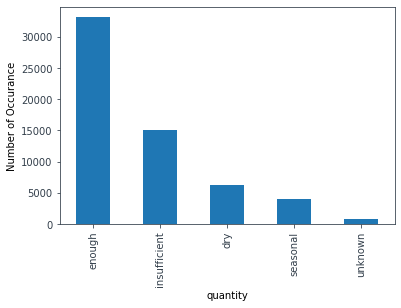

In [2203]:
data.quantity.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('quantity')
plt.ylabel('Number of Occurance')

In [2204]:
data.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

Text(0, 0.5, 'Number of Occurance')

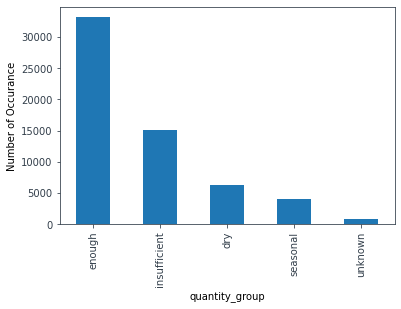

In [2205]:
data.quantity_group.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('quantity_group')
plt.ylabel('Number of Occurance')

In [2206]:
data.source.value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

Text(0, 0.5, 'Number of Occurance')

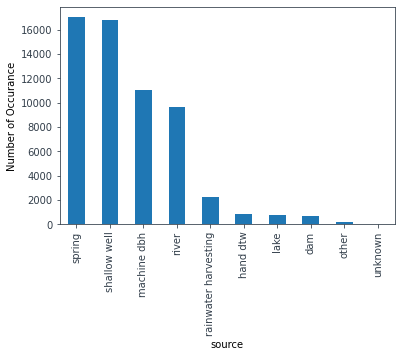

In [2207]:
data.source.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('source')
plt.ylabel('Number of Occurance')

In [2208]:
data.source_type.value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

Text(0, 0.5, 'Number of Occurance')

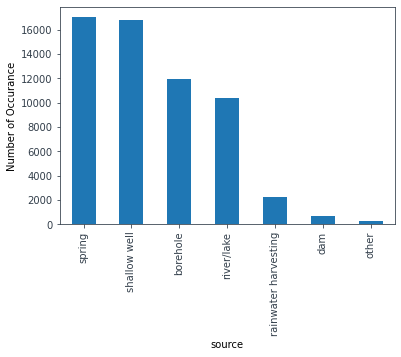

In [2209]:
data.source_type.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('source')
plt.ylabel('Number of Occurance')

In [2210]:
data.source_class.value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

Text(0, 0.5, 'Number of Occurance')

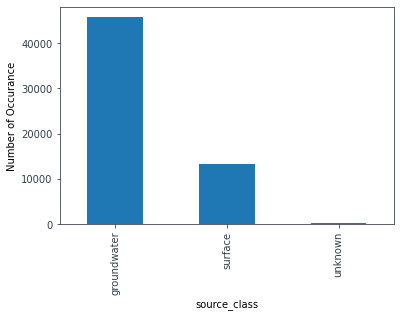

In [2211]:
data.source_class.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('source_class')
plt.ylabel('Number of Occurance')

In [2212]:
data.waterpoint_type.value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

Text(0, 0.5, 'Number of Occurance')

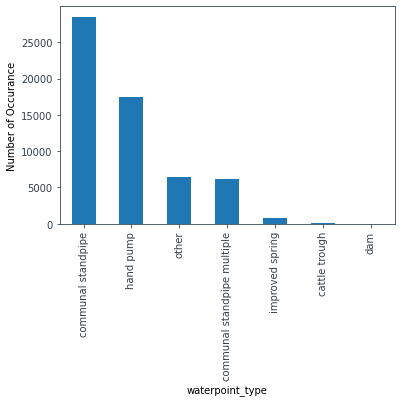

In [2213]:
data.waterpoint_type.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('waterpoint_type')
plt.ylabel('Number of Occurance')

In [2214]:
data.waterpoint_type_group.value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

Text(0, 0.5, 'Number of Occurance')

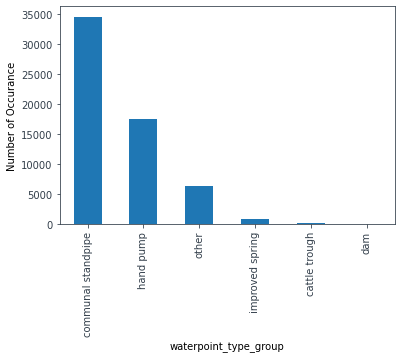

In [2215]:
data.waterpoint_type_group.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('waterpoint_type_group')
plt.ylabel('Number of Occurance')

###2.2.3- Highly Cardinal Features, with Missing value: funder, installer, wpt_name, subvillage, scheme_management, scheme_name

These features are also highly cardinal but have missing values as well. We will create a "Missing" category for them since there are so many NaN. We will use rare lable encoding to deal with high cardinality, which has to be done in feature engineering stage, after the train and test split.

In [2216]:
#Check for missing values in funder
df_categorical_features.funder.isnull().sum()

3635

In [2217]:
data.funder.fillna('Missing', inplace=True)
test.funder.fillna('Missing', inplace=True)

In [2218]:
data.funder.value_counts().sort_values(ascending=False)

Government Of Tanzania     9084
Missing                    3635
Danida                     3114
Hesawa                     2202
Rwssp                      1374
                           ... 
Owner Pingo C                 1
Mzee Salum Bakari Darus       1
Masista                       1
Dasp Ltd                      1
Samlo                         1
Name: funder, Length: 1898, dtype: int64

In [2219]:
funder_once_occurance_df = data.groupby('funder').filter(lambda x: len(x) < 2 )
# funder_once_occurance_df.head()
once_funder_index = funder_once_occurance_df.id.tolist()
print(len(once_funder_index))
# data.loc[data['id'].isin(once_funder_index), 'funder'] = "once"

974


In [2220]:
#Check for missing values in installer
df_categorical_features.installer.isnull().sum()

3655

In [2221]:
data.installer.fillna('Missing', inplace=True)
test.installer.fillna('Missing', inplace=True)

In [2222]:
data.installer.value_counts().sort_values(ascending=False)

DWE           17402
Missing        3655
Government     1825
RWE            1206
Commu          1060
              ...  
Mr Luo            1
VWT               1
Msudi             1
O &               1
SELEPTA           1
Name: installer, Length: 2146, dtype: int64

In [2223]:
installer_once_occurance_df = data.groupby('installer').filter(lambda x: len(x) < 2 )
# installer_once_occurance_df.head()
once_installer_index = installer_once_occurance_df.id.tolist()
print(len(once_installer_index))
# data.loc[data['id'].isin(once_installer_index), 'installer'] = "once"

1098


wpt_name has many 'none' values, we will change them to NaN and replace them with a category called missing, this can be done now before spliting.

In [2224]:
wpt_name_none_index = data[data.wpt_name=='none'].id.tolist()
data.loc[data['id'].isin(wpt_name_none_index), 'wpt_name']= np.NaN

In [2225]:
data.wpt_name.fillna('Missing', inplace=True)
test.wpt_name.fillna('Missing', inplace=True)

In [2226]:
data.wpt_name.value_counts().sort_values(ascending=False)

Missing            3563
Shuleni            1748
Zahanati            830
Msikitini           535
Kanisani            323
                   ... 
Mukashalakima         1
Nholo                 1
Majembwa              1
Kwa Mzee Jonas        1
Kwa Mzee Lugawa       1
Name: wpt_name, Length: 37400, dtype: int64

In [2227]:
wpt_name_once_occurance_df = data.groupby('wpt_name').filter(lambda x: len(x) < 2 )
# wpt_name_once_occurance_df.head()
once_wpt_name_index = wpt_name_once_occurance_df.id.tolist()
print(len(once_wpt_name_index))
# data.loc[data['id'].isin(once_wpt_name_index), 'wpt_name'] = "once"

32928


In [2228]:
data.subvillage.isnull().sum()

371

In [2229]:
data.subvillage.fillna('Missing', inplace=True)
test.subvillage.fillna('Missing', inplace=True)

In [2230]:
data.subvillage.value_counts().sort_values(ascending=False)

Madukani        508
Shuleni         506
Majengo         502
Kati            373
Missing         371
               ... 
Nakansindwi       1
Omurutenge        1
Ihagaha           1
Ngomba Chini      1
Kikatanyemba      1
Name: subvillage, Length: 19288, dtype: int64

In [2231]:
subvillage_once_occurance_df = data.groupby('subvillage').filter(lambda x: len(x) < 2 )
# subvillage_once_occurance_df.head()
once_subvillage_index = subvillage_once_occurance_df.id.tolist()
print(len(once_subvillage_index))
# data.loc[data['id'].isin(once_subvillage_index), 'subvillage'] = "once"

9424


In [2232]:
data.scheme_management.isnull().sum()

3877

In [2233]:
data.scheme_management.fillna('Missing', inplace=True)
test.scheme_management.fillna('Missing', inplace=True)

In [2234]:
data.scheme_management.value_counts().sort_values(ascending=False)

VWC                 36793
WUG                  5206
Missing              3877
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

scheme_management has one 'none' value, we will replace it with the "other" cateory.

In [2235]:
scheme_management_none_index = data[data.scheme_management=='None'].id.tolist()
data.loc[data['id'].isin(scheme_management_none_index), 'scheme_management']= 'Other'

Text(0, 0.5, 'Number of Occurance')

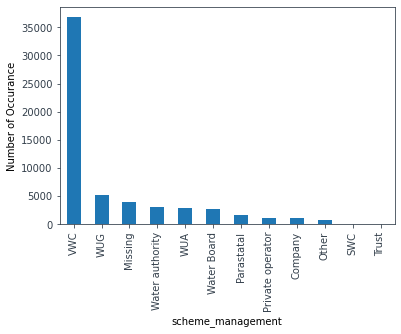

In [2236]:
data.scheme_management.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('scheme_management')
plt.ylabel('Number of Occurance')

scheme_name has 'None' categort, which we will leave it as category "None"

In [2237]:
data.scheme_name.isnull().sum()

28166

In [2238]:
data.scheme_name.fillna('Missing', inplace=True)
test.scheme_name.fillna('Missing', inplace=True)

In [2239]:
data.scheme_name.value_counts()

Missing                    28166
K                            682
None                         644
Borehole                     546
Chalinze wate                405
                           ...  
Visiga water supplly           1
Emanyata pipelines             1
Magundi water supply           1
Imalampaka water supply        1
Mtawanya                       1
Name: scheme_name, Length: 2697, dtype: int64

In [2240]:
scheme_name_once_occurance_df = data.groupby('scheme_name').filter(lambda x: len(x) < 2 )
# scheme_name_once_occurance_df.head()
once_scheme_name_index = scheme_name_once_occurance_df.id.tolist()
print(len(once_scheme_name_index))
# data.loc[data['id'].isin(once_scheme_name_index), 'scheme_name'] = "once"

712


###2.2.4- Boolian Features, with Missing Values: public_meeting, permit

In [2241]:
data.public_meeting.isnull().sum()

3334

In [2242]:
data.public_meeting.fillna('Missing', inplace=True)
test.public_meeting.fillna('Missing', inplace=True)

In [2243]:
data.public_meeting = data.public_meeting.replace({True: 'Yes', False: 'No'})

Text(0, 0.5, 'Number of Occurance')

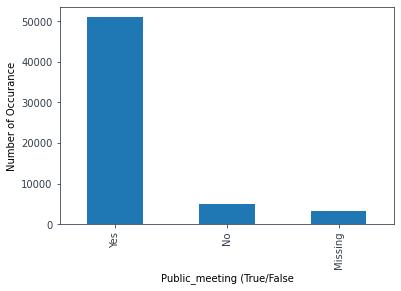

In [2244]:
data.public_meeting.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('Public_meeting (True/False')
plt.ylabel('Number of Occurance')

In [2245]:
data.permit.isnull().sum()

3056

In [2246]:
data.permit.fillna('Missing', inplace=True)
test.permit.fillna('Missing', inplace=True)

In [2247]:
data.permit = data.permit.replace({True: 'Yes', False: 'No'})

Text(0, 0.5, 'Number of Occurance')

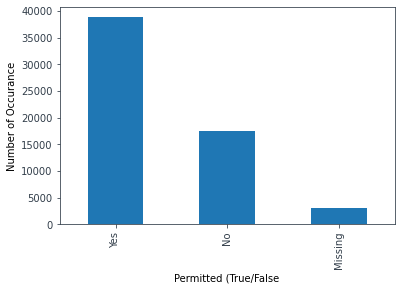

In [2248]:
data.permit.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('Permitted (True/False')
plt.ylabel('Number of Occurance')

###2.2.5- No value features
Some categorical features have only one unique instance

In [2249]:
data.recorded_by.value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [2250]:
data = data.drop(['recorded_by'], axis=1)

In [2251]:
test = test.drop(['recorded_by'], axis=1)

##2.3- Date and Time Features

###2.3.1. date_recorded
The date the row was entered
* Date recorded does not add much value by itself, we might only need the year. So, only the year row was entere is keeped. The other info of the feature can be used to find the day of the week, month, season, etc. of row recorded. The season might add some vale since it can be rainy or dry season in Tanzania. We will extract the season by percipitation amounts and add it as a new feature to the dataset. 
*Percipitation amount around the date the row was recorded can be valuable info, percipitation_amount above 100mm is assumed "high" and lower than 100mm assumed "low", indicating rainy and dry seasons. 

In [2252]:
data.date_recorded.isnull().sum()

0

In [2253]:
# data.info()

In [2254]:
data.date_recorded = pd.to_datetime(data.date_recorded)

In [2255]:
data['year_recorded'] = data.date_recorded.dt.year

In [2256]:
data['month_recorded'] = data.date_recorded.dt.month

In [2257]:
data['day_recorded'] = data.date_recorded.dt.weekday

In [2258]:
data['quarte_recorded'] = data.date_recorded.dt.quarter

In [2259]:
percipitation_range=[0,1,2,3,4]
percipitation_range = pd.DataFrame(percipitation_range, columns=['percipitation_range'])
percipitation_range

,percipitation_range
0,0
1,1
2,2
3,3
4,4


In [2260]:
data['month_recorded'].unique()

array([ 3,  2,  1,  7, 10, 11,  8,  9,  4,  5,  6, 12])

In [2261]:
range(len(data))

range(0, 59400)

In [2262]:
data.month_recorded[20]==1

False

In [2263]:
data['percipitation_class']=data['month_recorded']

In [2264]:
for i in range(len(data)):
  if data.month_recorded[i] == 1 | 3:
    data['percipitation_class'][i] = 4
  if data.month_recorded[i] == 12:
    data['percipitation_class'][i] = 3
  if data.month_recorded[i] == 2 | 4:
    data['percipitation_class'][i] = 2
  if data.month_recorded[i] == 11:
    data['percipitation_class'][i] = 1
  if data.month_recorded[i] == 5|6|7|8|9|10:
    data['percipitation_class'][i] = 0

<ipython-input-2264-e21c82653db7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['percipitation_class'][i] = 4
<ipython-input-2264-e21c82653db7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['percipitation_class'][i] = 1
<ipython-input-2264-e21c82653db7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['percipitation_class'][i] = 2
<ipython-input-2264-e21c82653db7>:5: SettingWithCopyWarning: 
A value is trying to be

In [2265]:
# data.year_recorded = data.date_recorded.str.replace('-','')
# data.year_recorded = data.year_recorded.str[:4]
# data.year_recorded = data.year_recorded.astype(int)

In [2266]:
# test.date_recorded = test.date_recorded.str.replace('-','')
# test.date_recorded = test.date_recorded.str[:4]
# test.date_recorded = test.date_recorded.astype(int)

In [2267]:
data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,year_recorded,month_recorded,day_recorded,quarte_recorded,percipitation_class
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,Missing,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,Yes,VWC,Roman,No,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011,3,0,1,4
1,8776,984.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,Missing,Other,Missing,Yes,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,2013,3,2,1,4
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,Yes,VWC,Nyumba ya mungu pipe scheme,Yes,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,2013,2,0,1,2
3,67743,984.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,Yes,VWC,Missing,Yes,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,2013,1,0,1,1
4,19728,984.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,Yes,Missing,Missing,Yes,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,2011,7,2,3,7


###2.1.10- construction_year
The year the waterpoint was constructed. This feature has so many 0 values, 20709, that does not make sense. The next most frequent year is 2645, the ratio to the next frequent i about 10 times. Replacing the year zero that we assume that are missing data, with any specific year in the dataset, mean /mode will skew the data drastically and will over represent one class. Thus, doing so is not adding any value to the model. We will distribute them over all years to keep the distribution, based on ration of those year in the total number of years. We will also add an indicating feature to flag the imputed year to the model.
* This step has to happen after test and train split so our model does not overfit and give us misleading results.
* we can calculate the age of the well at the date of recording the row.


In [2268]:
data.construction_year.value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

In [2269]:
# test.construction_year.value_counts()

Text(0, 0.5, 'Number of Occurance')

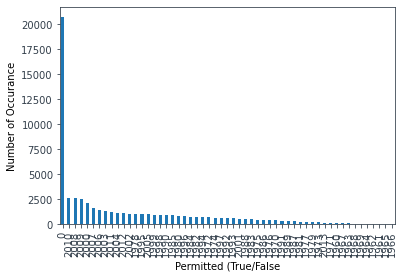

In [2270]:
data.construction_year.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('Permitted (True/False')
plt.ylabel('Number of Occurance')

Text(0, 0.5, 'Number of Occurance')

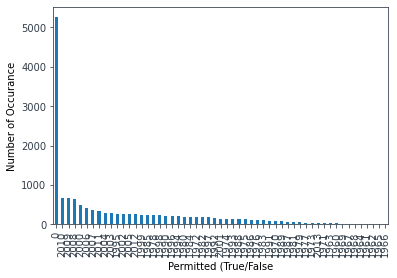

In [2271]:
test.construction_year.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('Permitted (True/False')
plt.ylabel('Number of Occurance')

In [2272]:
# construction_year_zero_index = data[data.construction_year==0].id.tolist()
# data.loc[data['id'].isin(construction_year_zero_index), 'construction_year']= np.NaN
# data['construction_year'].fillna(1950, inplace=True)

# # fillna('Missing', inplace=True)


In [2273]:
# construction_year_zero_index = data[data.construction_year==0].id.tolist()
# data.loc[data['id'].isin(construction_year_zero_index), 'construction_year']= np.NaN
# data['construction_year'].fillna(data['construction_year'].mode()[0], inplace=True)

 FE References


https://maxhalford.github.io/blog/target-encoding/

https://towardsdatascience.com/target-encoding-for-multi-class-classification-c9a7bcb1a53

https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64#:~:text=From%20the%20documentation%20linked%20above,over%20all%20the%20training%20data.%E2%80%9D

https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/target-encoding.html

https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/

https://www.kaggle.com/code/ryanholbrook/target-encoding

https://www.rasgoml.com/feature-engineering-tutorials/how-to-do-target-encoding

https://feature-engine.readthedocs.io/en/latest/

https://www.dropbox.com/sh/2vtm7k5maiyqrob/AAD7fm7Xwk6Ye9G54pgFRdFea?dl=0

https://queensu.udemy.com/course/feature-engineering-for-machine-learning/learn/lecture/9446014#overview

Target Encoding
Target encoding is a Baysian encoding technique.

Bayesian encoders use information from dependent/target variables to encode the categorical data.

In target encoding, we calculate the mean of the target variable for each category and replace the category variable with the mean value. In the case of the categorical target variables, the posterior probability of the target replaces each category.

In [2274]:
# import category_encoders as ce
# import pandas as pd
# data=pd.DataFrame({'City':[
# 'Delhi','Mumbai','Hydrabad','Chennai','Bangalore','Delhi','Hydrabad','Bangalore','Delhi'
# ]})

# #Create object for one-hot encoding
# encoder=ce.OneHotEncoder(cols='City',handle_unknown='return_nan',return_df=True,use_cat_names=True)

# #Original Data
# data

In [2275]:
for i in data.columns:
  data[i].fillna(data[i].mode()[0], inplace=True)
for i in test.columns:
  test[i].fillna(test[i].mode()[0], inplace=True)
data.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

In [2276]:
# #Fit and transform Data
# data_encoded = encoder.fit_transform(data)
# data_encoded

In [2277]:
# #import the libraries
# import pandas as pd
# import category_encoders as ce

# #Create the Dataframe
# data=pd.DataFrame({'class':['A,','B','C','B','C','A','A','A'],'Marks':[50,30,70,80,45,97,80,68]})

# #Create target encoding object
# encoder=ce.TargetEncoder(cols='class') 

# #Original Data
# Data

#3- Feature Engineering
Rare values are categories within a categorical variable that are present only in a small percentage of the observations. There is no rule of thumb to determine how small is a small percentage, but typically, any value below 5 % can be considered rare.

* Grouping categories into rare for variables that show low cardinality may or may not improve model performance, however, we tend to re-group them into a new category to smooth model deployment.

* Grouping categories into rare for variables with high cardinality, tends to improve model performance as well.

https://github.com/solegalli/feature-engineering-for-machine-learning/blob/main/Section-06-Categorical-Encoding/06.10-Engineering-Rare-Categories.ipynb

The identification of rare labels should be done using only the training set, and then propagated to the test set. Rare labels should be identified in the training set only. In practice, what we will do is identify non-rare labels, and then any other label, either in the train or the test or future live data that is not in that list of non-rare labels, will be re=grouped into the new category.

In [2278]:
# pip install feature_engine

In [2279]:
from feature_engine.encoding import RareLabelEncoder
pd.set_option('display.max_columns', None)

##3.1- Rare Value Encoding for Categorical Features
features like 'funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name' have so many values as 1, 2, 3 etc. We left them for now

https://feature-engine.readthedocs.io/en/0.6.x_a/encoders/RareLabelCategoricalEncoder.html

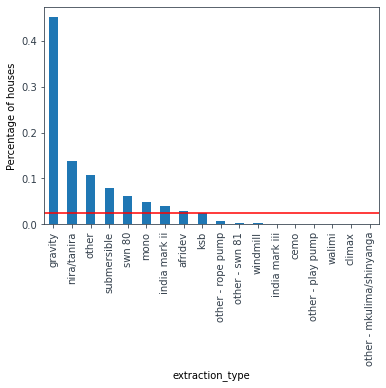

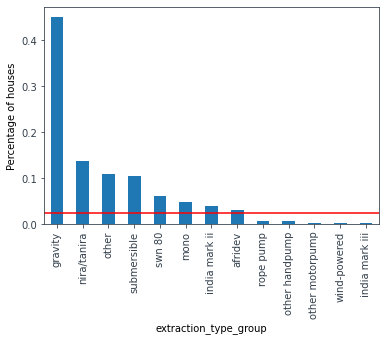

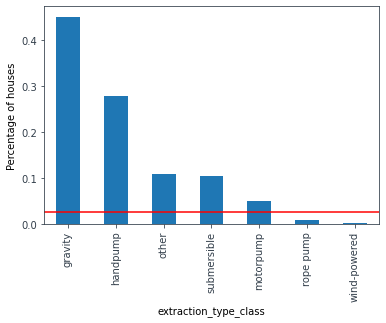

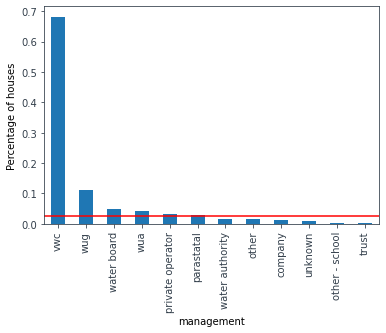

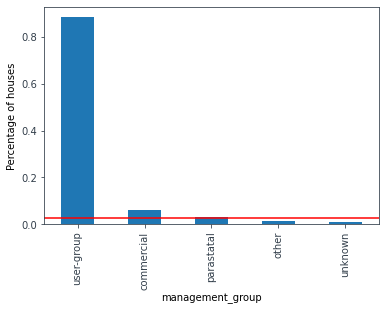

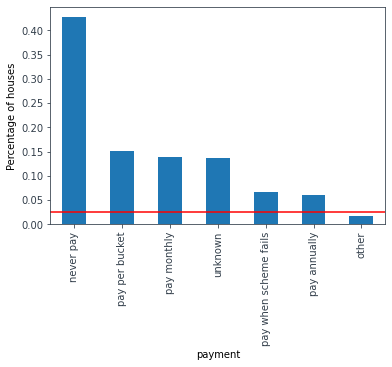

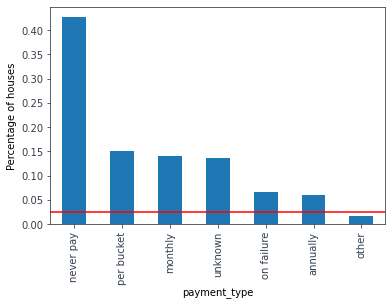

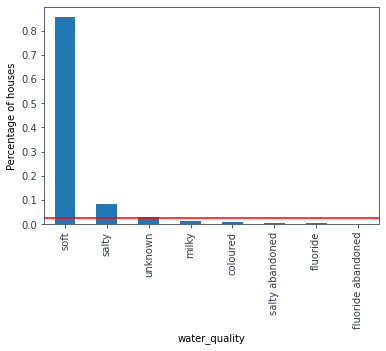

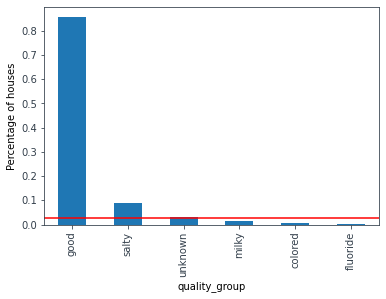

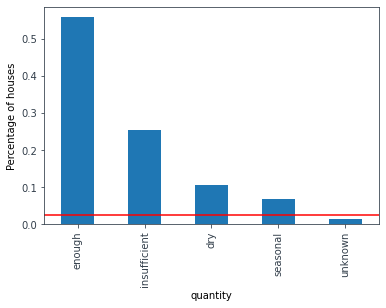

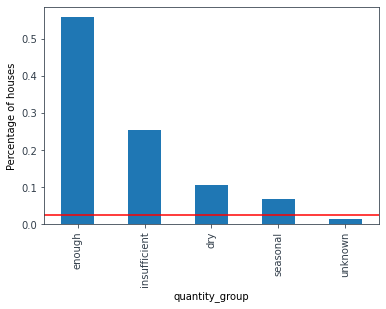

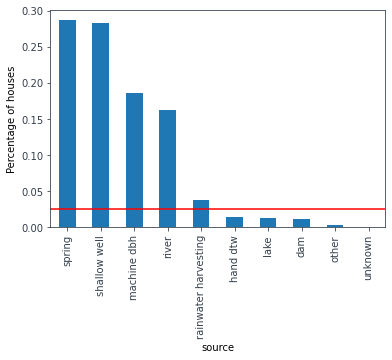

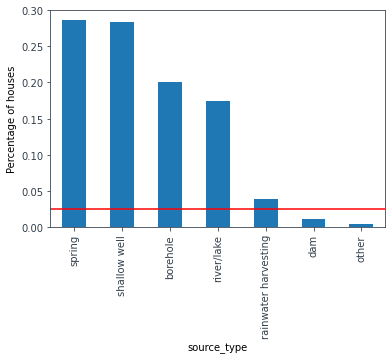

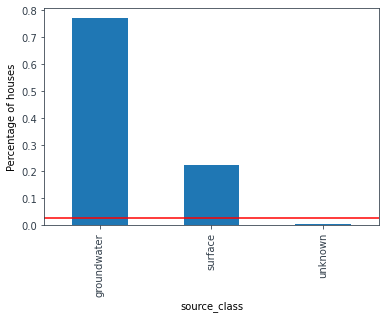

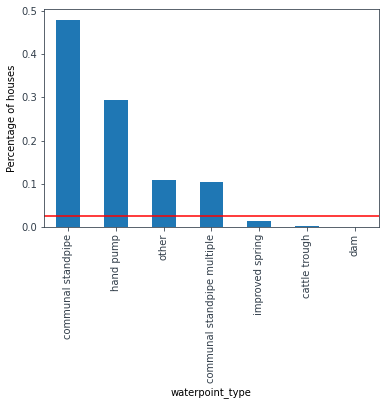

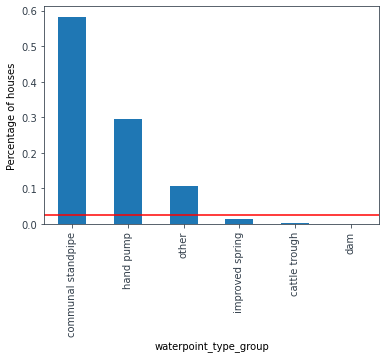

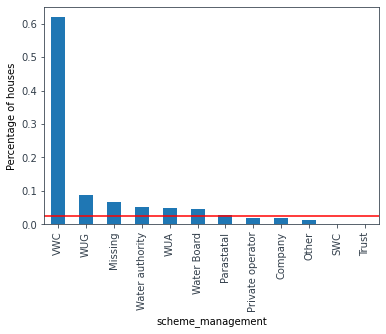

In [2280]:
for col in ['extraction_type', 
               'extraction_type_group', 'extraction_type_class', 'management', 
               'management_group', 'payment', 'payment_type', 'water_quality',
               'quality_group', 'quantity', 'quantity_group', 'source', 
               'source_type', 'source_class', 'waterpoint_type', 
               'waterpoint_type_group',
               'scheme_management'
            ]:

    temp_df = pd.Series(data[col].value_counts() / len(data) )

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.025, color='red')
    fig.set_ylabel('Percentage of houses')
    plt.show()

In [2292]:
rare_encoder = RareLabelEncoder(
    tol=0.025,  # minimal percentage to be considered non-rare
    n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
    variables=['extraction_type',
               'extraction_type_group', 'extraction_type_class', 'management', 
               'management_group', 'payment', 'payment_type', 'water_quality',
               'quality_group', 'quantity', 'quantity_group', 'source', 
               'source_type', 'source_class', 'waterpoint_type',
               'waterpoint_type_group',
               'scheme_management'], # variables to re-group
    replace_with='Rare'
)  

In [2293]:
rare_encoder_lga = RareLabelEncoder(
    tol=0.007,  # minimal percentage to be considered non-rare
    n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
    max_n_categories = 75,
    variables=['lga'], # variables to re-group
    replace_with='Rare'
)  

In [2294]:
rare_encoder.fit(data)

/usr/local/lib/python3.8/dist-packages/feature_engine/encoding/rare_label.py:199: UserWarning: The number of unique categories for variable management_group is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/feature_engine/encoding/rare_label.py:199: UserWarning: The number of unique categories for variable water_quality is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/feature_engine/encoding/rare_label.py:199: UserWarning: The number of unique categories for variable quality_group is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/feature_engine/encoding/rare_label.py:199: UserWarning: The number of unique categories for variable waterpoint_type_group is less than that indicated in n_categor

RareLabelEncoder(n_categories=4, tol=0.025,
                 variables=['extraction_type', 'extraction_type_group',
                            'extraction_type_class', 'management',
                            'management_group', 'payment', 'payment_type',
                            'water_quality', 'quality_group', 'quantity',
                            'quantity_group', 'source', 'source_type',
                            'source_class', 'waterpoint_type',
                            'waterpoint_type_group', 'scheme_management'])

In [2295]:
rare_encoder_lga.fit(data)

RareLabelEncoder(max_n_categories=75, n_categories=4, tol=0.007,
                 variables=['lga'])

In [2285]:
# rare_encoder.variables_

In [2286]:
# rare_encoder.encoder_dict_

In [2296]:
data = rare_encoder.transform(data)
# X_test = rare_encoder.transform(X_test.fillna('Missing'))

In [2297]:
data = rare_encoder_lga.transform(data)
# X_test = rare_encoder.transform(X_test.fillna('Missing'))

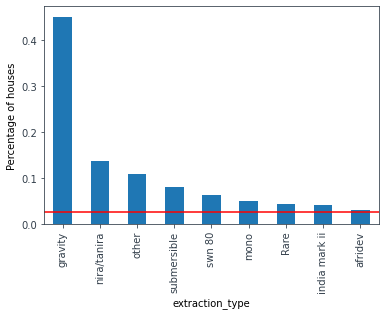

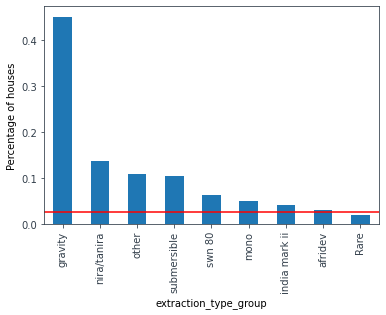

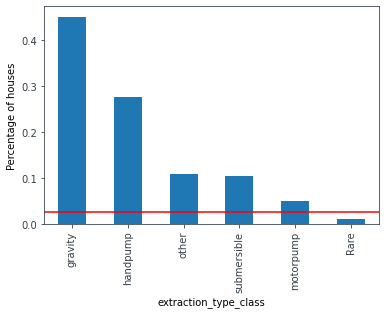

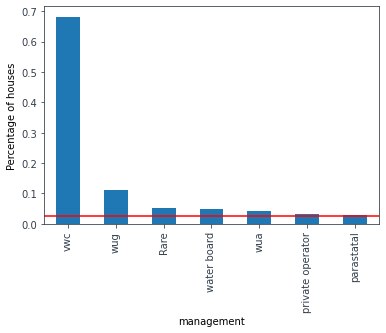

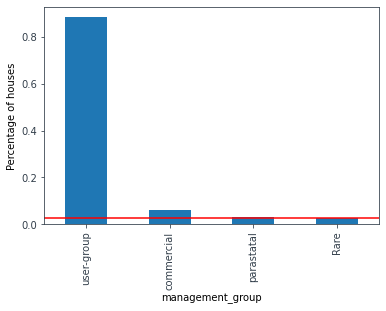

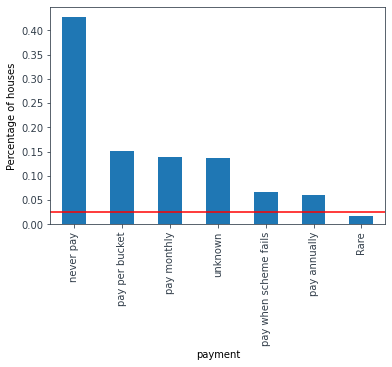

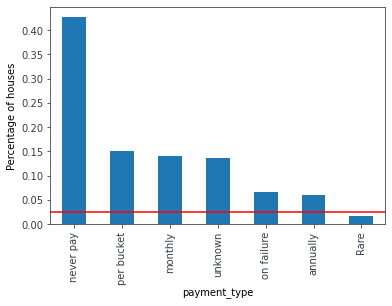

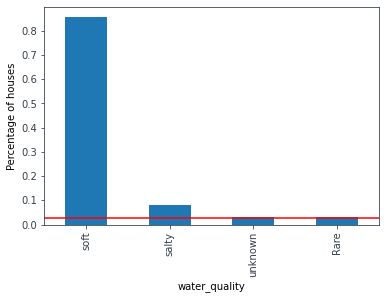

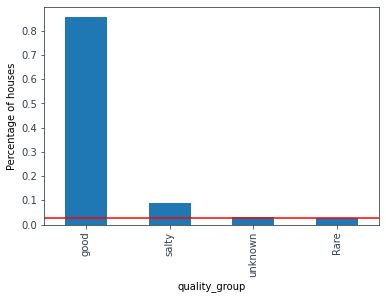

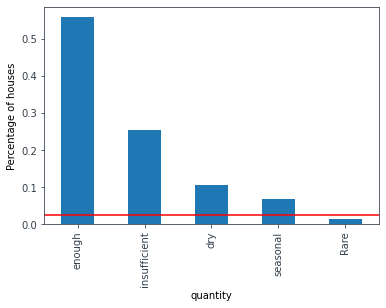

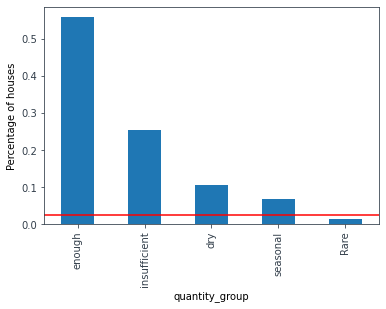

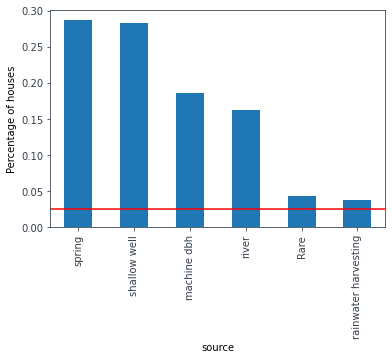

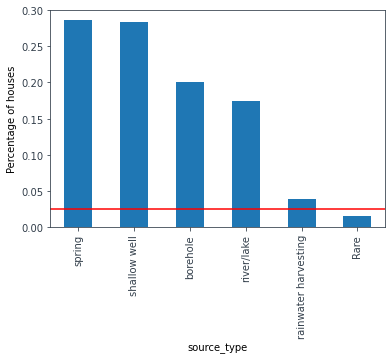

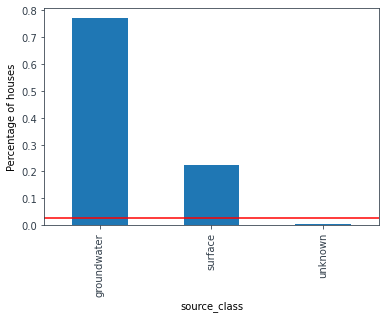

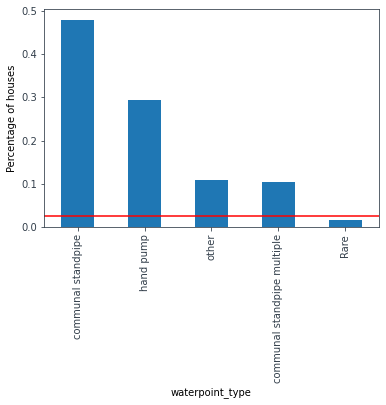

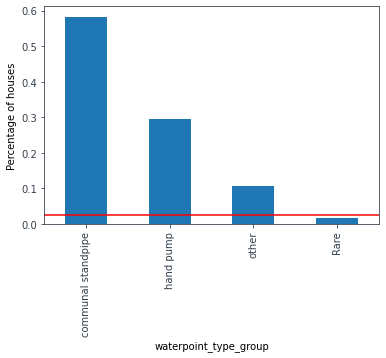

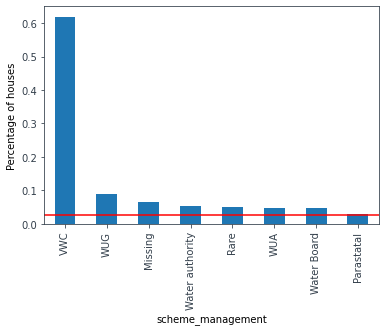

In [2298]:
for col in ['extraction_type', 
               'extraction_type_group', 'extraction_type_class', 'management', 
               'management_group', 'payment', 'payment_type', 'water_quality',
               'quality_group', 'quantity', 'quantity_group', 'source', 
               'source_type', 'source_class', 'waterpoint_type',
               'waterpoint_type_group',
               'scheme_management']:

    temp_df = pd.Series(data[col].value_counts() / len(data) )

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.025, color='red')
    fig.set_ylabel('Percentage of houses')
    plt.show()

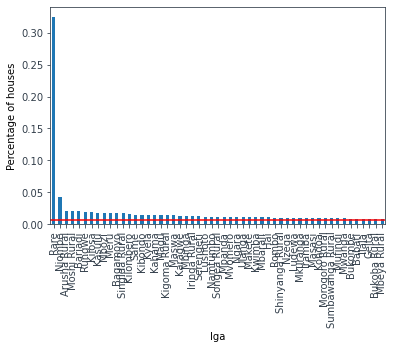

In [2290]:
temp_df = pd.Series(data['lga'].value_counts() / len(data) )

# make plot with the above percentages
fig = temp_df.sort_values(ascending=False).plot.bar()
fig.set_xlabel('lga')

    # add a line at 5 % to flag the threshold for rare categories
fig.axhline(y=0.007, color='red')
fig.set_ylabel('Percentage of houses')
plt.show()

In [2299]:
# check for cardinality in categorical variables

for var in ['extraction_type', 'lga', 'basin', 'region', 'public_meeting', 'permit',
               'extraction_type_group', 'extraction_type_class', 'management', 
               'management_group', 'payment', 'payment_type', 'water_quality',
               'quality_group', 'quantity', 'quantity_group', 'source', 
               'source_type', 'source_class', 'waterpoint_type', 
               'waterpoint_type_group',
               'scheme_management']:
    
    print(var, ' contains ', len(data[var].unique()), ' labels')


extraction_type  contains  9  labels
lga  contains  53  labels
basin  contains  9  labels
region  contains  21  labels
public_meeting  contains  3  labels
permit  contains  3  labels
extraction_type_group  contains  9  labels
extraction_type_class  contains  6  labels
management  contains  7  labels
management_group  contains  4  labels
payment  contains  7  labels
payment_type  contains  7  labels
water_quality  contains  4  labels
quality_group  contains  4  labels
quantity  contains  5  labels
quantity_group  contains  5  labels
source  contains  6  labels
source_type  contains  6  labels
source_class  contains  3  labels
waterpoint_type  contains  5  labels
waterpoint_type_group  contains  4  labels
scheme_management  contains  8  labels


##2.2.1- Label Distribution
Multiclass Classification Labels, need to encode them

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

Text(0, 0.5, 'Number of Occurance')

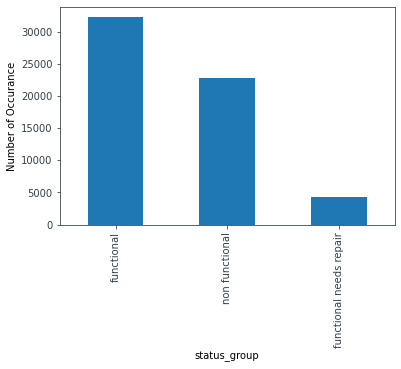

In [2092]:
data.status_group.value_counts().plot.bar()
plt.xlabel('status_group')
plt.ylabel('Number of Occurance')

In [2093]:
data.status_group.value_counts()


functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [2094]:
data.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [2095]:
label_encouder=LabelEncoder()
data.status_group = label_encouder.fit_transform(data.status_group)
data.status_group.head()

0    0
1    0
2    0
3    2
4    0
Name: status_group, dtype: int64

Text(0, 0.5, 'Number of Occurance')

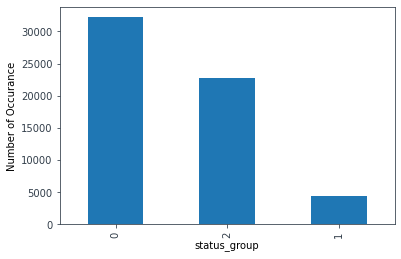

In [2096]:
data.status_group.value_counts().plot.bar()
plt.xlabel('status_group')
plt.ylabel('Number of Occurance')

In [2097]:
# data.info()

##3.2- Target Value Encoding for Categorical Features

###3.2.1- Explore original relationship between categorical variables and target

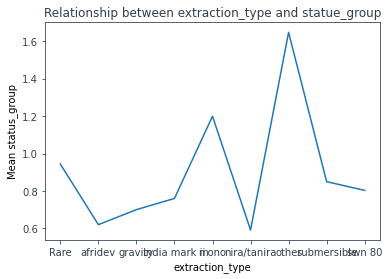

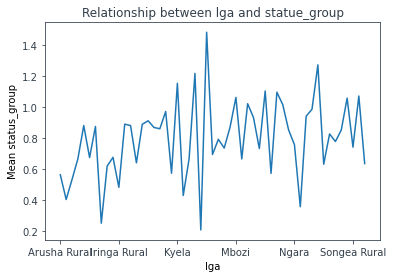

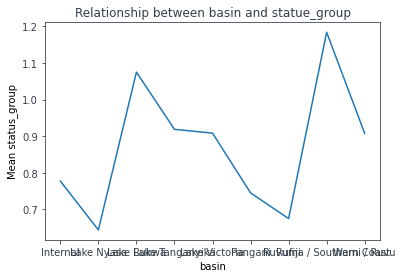

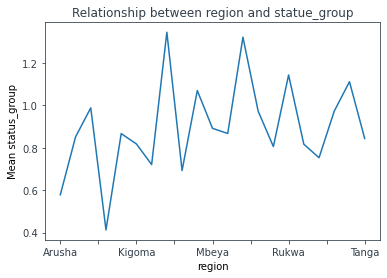

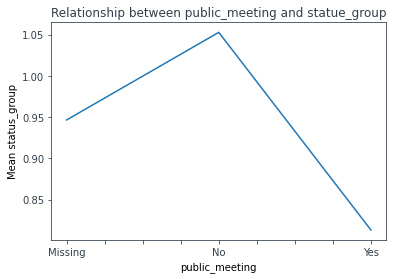

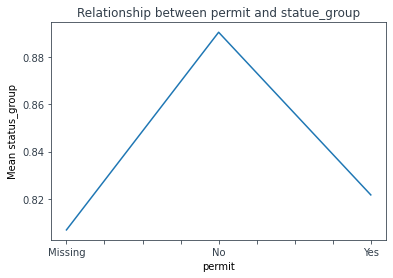

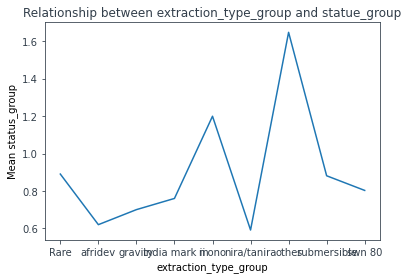

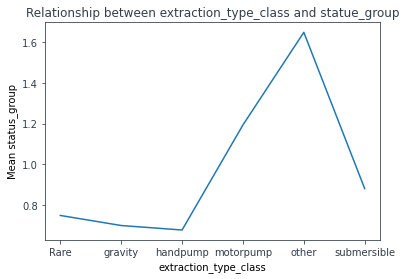

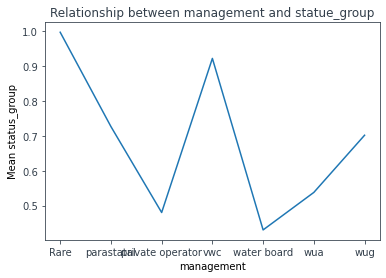

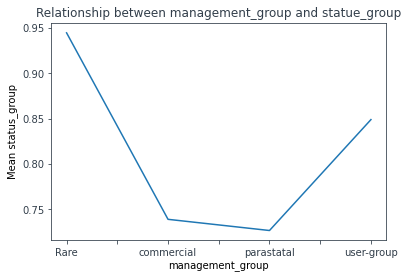

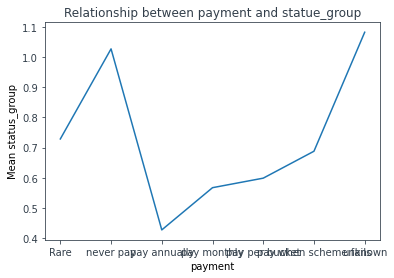

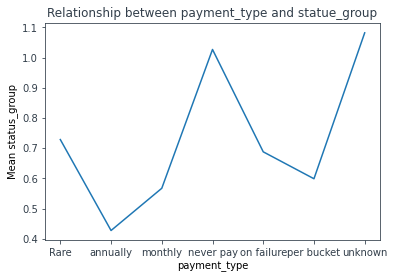

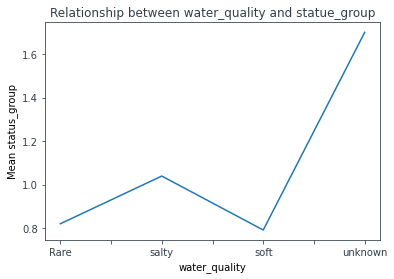

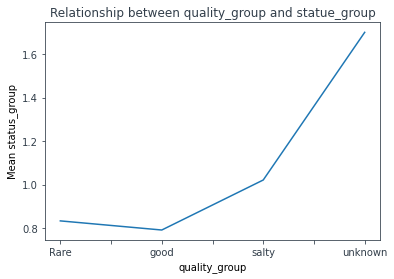

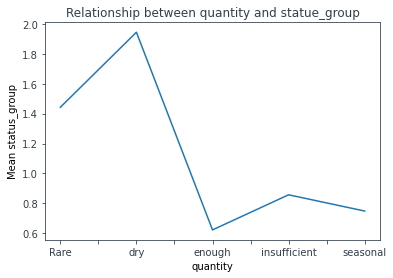

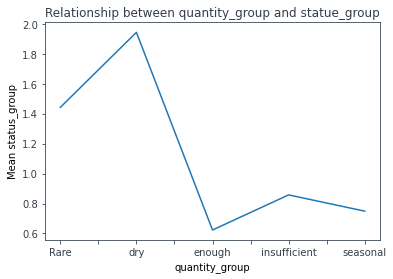

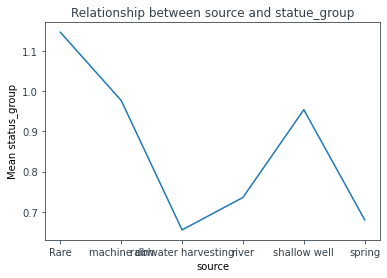

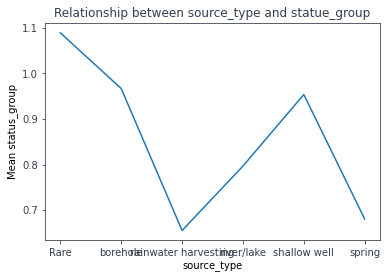

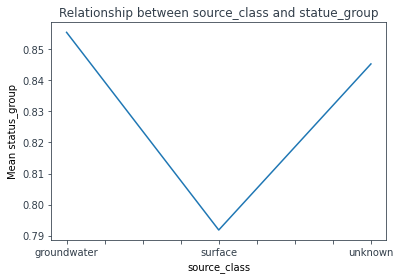

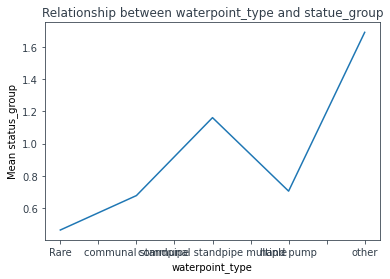

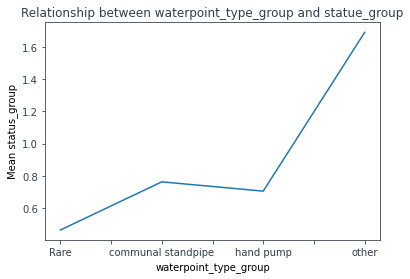

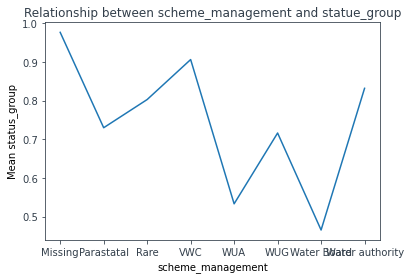

In [2098]:
# let's explore the relationship of the categories with the target

for var in ['extraction_type', 'lga', 'basin', 'region', 'public_meeting', 'permit',
               'extraction_type_group', 'extraction_type_class', 'management', 
               'management_group', 'payment', 'payment_type', 'water_quality',
               'quality_group', 'quantity', 'quantity_group', 'source', 
               'source_type', 'source_class', 'waterpoint_type', 
               'waterpoint_type_group',
               'scheme_management']:
    
    fig = plt.figure()
    fig = data.groupby([var])['status_group'].mean().plot()
    fig.set_title('Relationship between {} and statue_group'.format(var))
    fig.set_ylabel('Mean status_group')
    plt.show()

###3.2.2- Target Encoding with Feature Engine Package

In [2099]:
from feature_engine.encoding import MeanEncoder

In [2100]:
data = data.drop(['id'],axis=1)
# Y = data.status_group

In [2101]:
# data.head()

In [2102]:
mean_enc = MeanEncoder(
    variables=['extraction_type', 'lga', 'basin', 'region', 'public_meeting', 'permit',
               'extraction_type_group', 'extraction_type_class', 'management', 
               'management_group', 'payment', 'payment_type', 'water_quality',
               'quality_group', 'quantity', 'quantity_group', 'source', 
               'source_type', 'source_class', 'waterpoint_type', 
               'waterpoint_type_group',
               'scheme_management'])

In [2103]:
mean_enc.fit(data, data.status_group)

MeanEncoder(variables=['extraction_type', 'lga', 'basin', 'region',
                       'public_meeting', 'permit', 'extraction_type_group',
                       'extraction_type_class', 'management',
                       'management_group', 'payment', 'payment_type',
                       'water_quality', 'quality_group', 'quantity',
                       'quantity_group', 'source', 'source_type',
                       'source_class', 'waterpoint_type',
                       'waterpoint_type_group', 'scheme_management'])

In [2104]:
# mean_enc.encoder_dict_

In [2105]:
# mean_enc.variables_

In [2106]:
data = mean_enc.transform(data)
# X_test = mean_enc.transform(X_test)

# let's explore the result
# data.head()

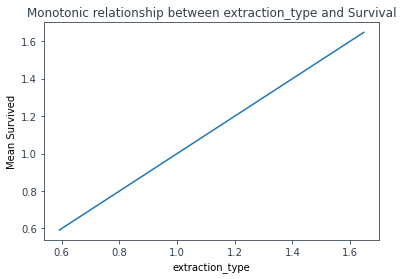

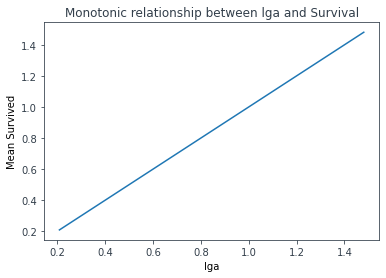

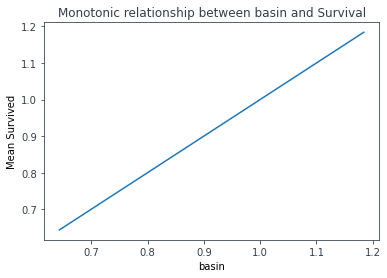

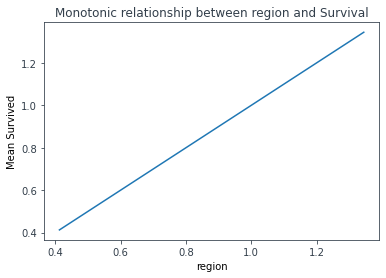

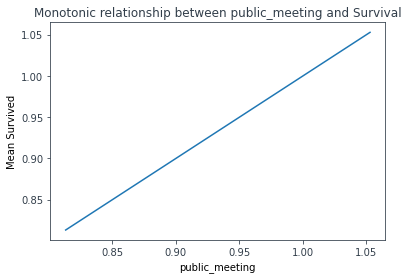

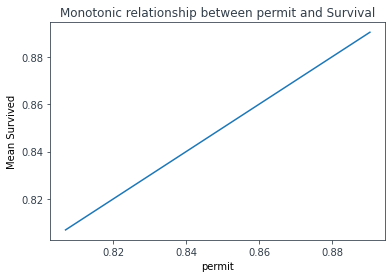

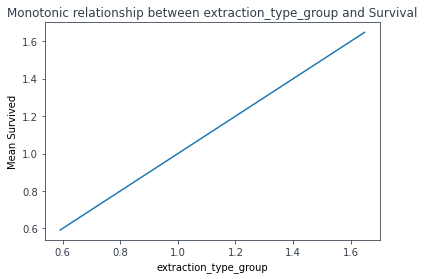

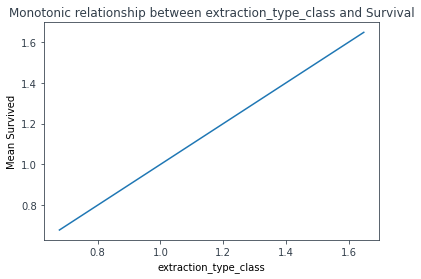

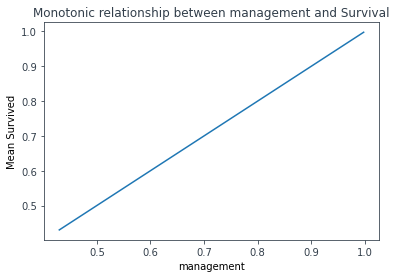

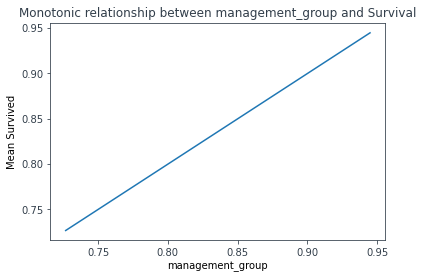

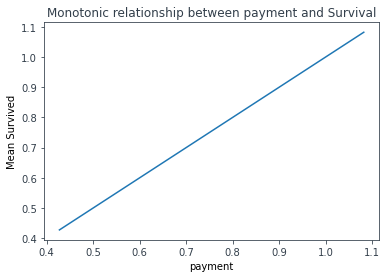

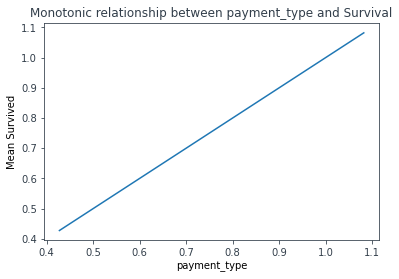

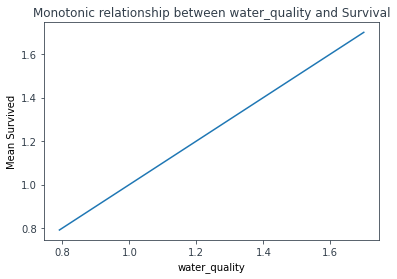

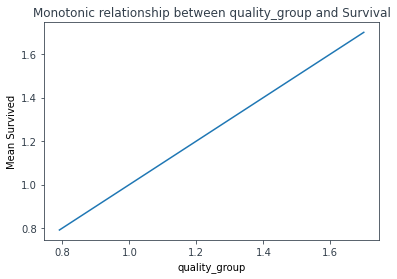

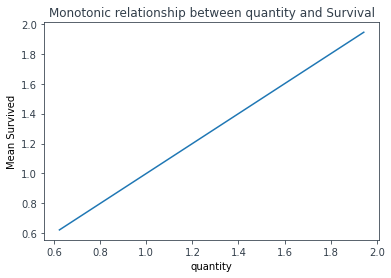

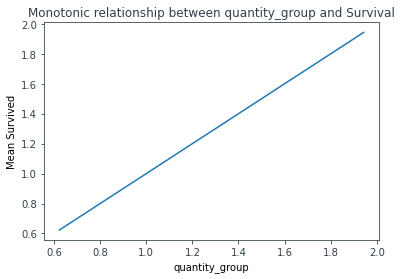

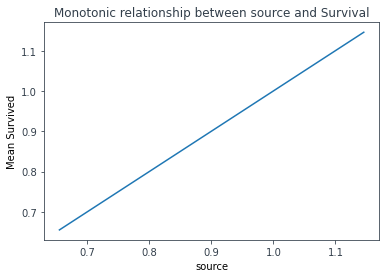

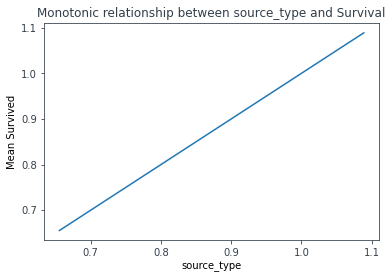

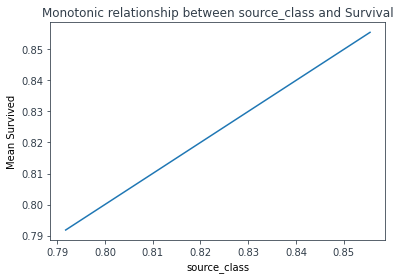

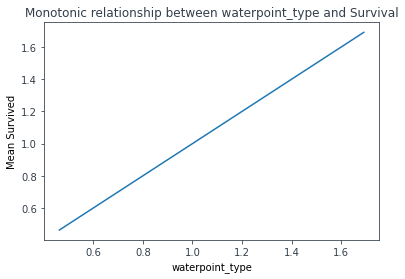

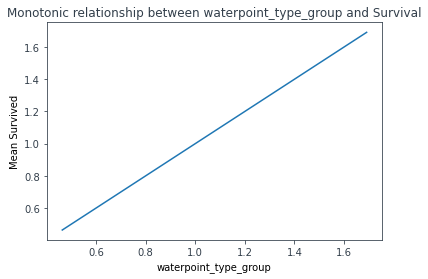

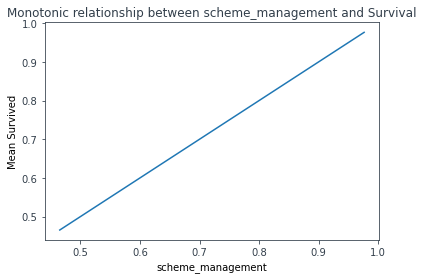

In [2107]:
# let's inspect the newly created monotonic relationship
# between the variables and the target

for var in ['extraction_type', 'lga', 'basin', 'region', 'public_meeting', 'permit',
               'extraction_type_group', 'extraction_type_class', 'management', 
               'management_group', 'payment', 'payment_type', 'water_quality',
               'quality_group', 'quantity', 'quantity_group', 'source', 
               'source_type', 'source_class', 'waterpoint_type', 
               'waterpoint_type_group',
               'scheme_management']:
    
    fig = plt.figure()
    fig = data.groupby([var])['status_group'].mean().plot()
    fig.set_title('Monotonic relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survived')
    plt.show()

##2.2.2- Object features encoding
* All the categorical features need to be encoded, used OrdinalEncoder

References: 

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html

https://datascience.stackexchange.com/questions/98137/separate-numerical-and-categorical-variables

In [2108]:
ordinal_encoder = OrdinalEncoder()

In [ ]:
# target_encoder = 

In [2109]:
df_categorical_features = data.select_dtypes(include='object')
df_categorical_features.columns

Index(['funder', 'installer', 'wpt_name', 'subvillage', 'ward', 'scheme_name'], dtype='object')

In [2110]:
for i in df_categorical_features.columns:
  data[i] = ordinal_encoder.fit_transform(data[i].values.reshape(-1,1))

In [ ]:
# for i in df_categorical_features.columns:
#   test[i] = ordinal_encoder.fit_transform(test[i].values.reshape(-1,1))

In [1927]:
data.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,year_recorded,month_recorded,day_recorded,quarte_recorded,percipitation_class
0,6000.0,2011-03-14,1370.0,1390,1519.0,34.938093,-9.856322,28856.0,0.643461,11808.0,0.412354,11,5,0.430851,1426.0,109,0.813295,0.905933,2246.0,0.890350,1999,0.700635,0.700635,0.700635,0.922631,0.849114,0.427512,0.427512,0.791294,0.791294,0.623034,0.623034,0.680454,0.680454,0.855505,0.677793,0.763032,0,2011,3,0,1,4
1,984.0,2013-03-06,469.0,1399,545.0,34.698766,-2.147466,37196.0,0.908177,15839.0,1.069578,20,2,0.777933,1576.0,280,0.946611,0.802614,1469.0,0.821708,2010,0.700635,0.700635,0.700635,0.701919,0.849114,1.026945,1.026945,0.791294,0.791294,0.857691,0.857691,0.655338,0.655338,0.791792,0.677793,0.763032,0,2013,3,2,1,4
2,25.0,2013-02-25,825.0,686,2049.0,37.460664,-3.821329,14572.0,0.744855,9074.0,0.692356,21,4,0.977501,1624.0,250,0.813295,0.905933,2122.0,0.821708,2009,0.700635,0.700635,0.700635,0.922631,0.849114,0.598887,0.598887,0.791294,0.791294,0.623034,0.623034,1.145744,1.088865,0.791792,1.161396,0.763032,0,2013,2,0,1,2
3,984.0,2013-01-28,1742.0,263,1853.0,38.486161,-11.155298,37286.0,1.184064,8982.0,1.321387,90,63,0.977501,1571.0,58,0.813295,0.905933,1469.0,0.821708,1986,0.849916,0.881534,0.881534,0.922631,0.849114,1.026945,1.026945,0.791294,0.791294,1.943804,1.943804,0.976524,0.966775,0.855505,1.161396,0.763032,2,2013,1,0,1,1
4,984.0,2011-07-13,20.0,0,119.0,31.130847,-1.825359,35530.0,0.908177,7698.0,0.866707,18,1,0.880674,1687.0,0,0.813295,0.976270,1469.0,0.821708,0,0.700635,0.700635,0.700635,0.997792,0.944814,1.026945,1.026945,0.791294,0.791294,0.749136,0.749136,0.655338,0.655338,0.791792,0.677793,0.763032,0,2011,7,2,3,7


Correlation Matrix

In [ ]:
# plt.figure(figsize=(10,8))
# cmap=data.corr()
# sns.heatmap(cmap)

#3- Train and Test Split and Feature Engineering

In [2111]:
X = data.drop(['date_recorded' , 'status_group'],axis=1)
Y = data.status_group
x_test=test.drop('id',axis=1)

In [ ]:
# data.head()

In [2112]:
x_train, x_valid, y_train, y_valid = train_test_split(X,Y, random_state = 0, test_size = 0.1, stratify = Y, shuffle=True)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((53460, 41), (5940, 41), (53460,), (5940,))

###3.1- Transforming features

The classes are imbalanced, used balanced parameter 

In [ ]:
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)
# x_test = scaler.transform(x_test) # The final test set

In [ ]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y=y_train)

class_weights = dict(zip(np.unique(y_train),class_weights))
class_weights 

# class_weights = dict(zip(np.unique(x_train), class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)))

{0: 0.6137843144008542, 1: 4.586872586872587, 2: 0.8674909940609483}

In [ ]:
# sns.displot(y_val)

In [ ]:
y_valid.value_counts()

0    3226
2    2282
1     432
Name: status_group, dtype: int64

#4- Building Models

##4.1- Logistic regression

####Fit the Logistic regression model and Tune Hyperparameter

In [2125]:
lr_sgd = SGDClassifier(
    loss = 'log',
    penalty = 'elasticnet',
    n_jobs = -1,
    random_state = 42,
    class_weight = 'balanced'
)

lr_sgd.fit(x_train, y_train)

SGDClassifier(class_weight='balanced', loss='log', n_jobs=-1,
              penalty='elasticnet', random_state=42)

* Hyperparameter Tuning

In [2126]:
params = {
    'alpha' : [0.001, 0.01, 0.1, 1.0, 10]
}
lr_hyperparam = GridSearchCV(lr_sgd, params, scoring='f1', cv=3, n_jobs = -1, verbose = 5, return_train_score = True)
lr_hyperparam.fit(x_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=3,
             estimator=SGDClassifier(class_weight='balanced', loss='log',
                                     n_jobs=-1, penalty='elasticnet',
                                     random_state=42),
             n_jobs=-1, param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 10]},
             return_train_score=True, scoring='f1', verbose=5)

In [2127]:
lr_hyperparam.best_params_

{'alpha': 0.001}

In [2128]:
lr_full = SGDClassifier(
    alpha = 0.001,
    loss = 'log',
    penalty = 'elasticnet',
    n_jobs = -1,
    random_state = 42,
    class_weight = 'balanced'
)

lr_full.fit(x_train, y_train)

SGDClassifier(alpha=0.001, class_weight='balanced', loss='log', n_jobs=-1,
              penalty='elasticnet', random_state=42)

####Perform Prediction and Display Results for Logistic regression




In [2129]:
lr_preds = lr_full.predict(x_valid)

              precision    recall  f1-score   support

           0       0.54      0.73      0.62      3226
           1       0.07      0.26      0.11       432
           2       0.62      0.01      0.02      2282

    accuracy                           0.42      5940
   macro avg       0.41      0.33      0.25      5940
weighted avg       0.54      0.42      0.35      5940



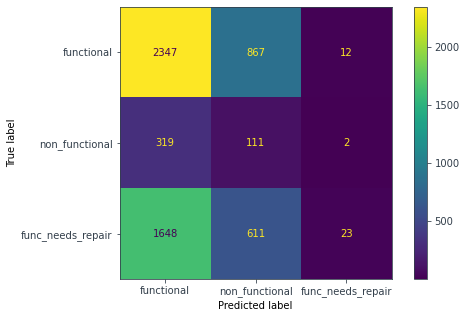

In [2130]:
print(classification_report(y_valid, lr_preds))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, lr_preds),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [2131]:
lr_table = PrettyTable()
lr_table.field_names = ['Model Name',
                  'Accuracy',
                  'F1-Score',
                  'Precision',
                  'Recall',
                  # 'Log-loss'
                 ]

lr_table.add_row([
    'Logistic Regression',
    accuracy_score(y_true = y_valid, y_pred = lr_preds),
    f1_score(y_true = y_valid, y_pred = lr_preds, average='weighted'),
    precision_score(y_true = y_valid, y_pred = lr_preds, average='weighted'),
    recall_score(y_true = y_valid, y_pred = lr_preds, average='weighted'),
    # log_loss(y_true = y_valid, y_pred = lr_preds)
])
print(lr_table)

+---------------------+--------------------+--------------------+--------------------+--------------------+
|      Model Name     |      Accuracy      |      F1-Score      |     Precision      |       Recall       |
+---------------------+--------------------+--------------------+--------------------+--------------------+
| Logistic Regression | 0.4176767676767677 | 0.3537128866570961 | 0.5393602029385739 | 0.4176767676767677 |
+---------------------+--------------------+--------------------+--------------------+--------------------+


####Feature Importances - Logistic Regression

<ipython-input-1950-98f99d594e09>:70: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
<ipython-input-1950-98f99d594e09>:71: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


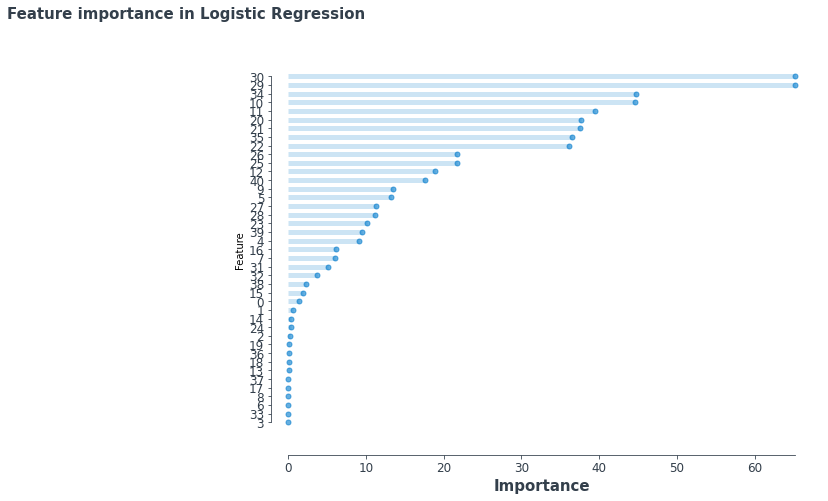

In [2132]:
pretty_importances_plot(
    np.abs(lr_full.coef_[0]), 
    [i for i in range(x_train.shape[1])],
    xlabel = 'Importance',
    ylabel = 'Feature',
    horizontal_label = 'Feature importance in Logistic Regression'
)

##4.4- ADABoostClassifier
The training algorithm involves starting with one decision tree, finding those examples in the training dataset that were misclassified, and adding more weight to those examples. Another tree is trained on the same data, although now weighted by the misclassification errors. This process is repeated until a desired number of trees are added.

https://machinelearningmastery.com/adaboost-ensemble-in-python/

https://www.datacamp.com/tutorial/adaboost-classifier-python#adaboost-classifier

https://towardsdatascience.com/the-ultimate-guide-to-adaboost-random-forests-and-xgboost-7f9327061c4f

https://vitalflux.com/differences-between-random-forest-vs-adaboost/

https://vitalflux.com/adaboost-algorithm-explained-with-python-example/#:~:text=Base%20estimators%20for%20Adaboost%20algorithm,in%20classifier%20with%20high%20variance.

https://techfor-today.com/hyperparameter-tuning-of-adaboost/

###4.4.1- Hyper Parameter Tuning for AdaBoosting - Sequential Approach

####4.4.1.1- The optimum number of trees in Adaboost
Create a function that will build various Ada boost models. And for the model, we will specify a different number of decision stumps starting from 50 to 1000.

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    Ada_models = dict()
    
    # number of decision stumps
    decision_stump= [10, 50, 100, 500]
        
#    using for loop to iterate though trees
    for i in decision_stump:
        
#         building model with specified trees
        models[str(i)] = AdaBoostClassifier(n_estimators=i, random_state=7)
    return models

The next step is to build a function for the validation of the models. In this case, we will use the cross-validation method. Let us build the function which returns the accuracy score of the models.

In [ ]:
# function for the validation of model
def evaluate_model(model, Input, Ouput):
    
    # defining the method of validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    
    
    # validating the model based on the accurasy score
    accuracy = cross_val_score(model, Input, Ouput, scoring='accuracy', cv=cv, n_jobs=-1, random_state=7)
    
#      accuracy score- hyperparameter tuning of Adaboost
    return accuracy

Now, we will call the above functions which will create the models and will evaluate them based on the accuracy score.

In [ ]:
# calling the build_models function
models = {}
models = build_models()

# creating list
results, names = list(), list()

# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    scores = evaluate_model(model, x_train, y_train)
    
    
    # appending the accuray socres in results
    results.append(scores)
    names.append(name)
    
    
    # printing results of hyperparameter tuning of Adaboost
    print('---->Stump tree (%s)---Accuracy( %.5f)' % (name, np.mean(scores)))

---->Stump tree (10)---Accuracy( 0.70557)
---->Stump tree (50)---Accuracy( 0.72437)
---->Stump tree (100)---Accuracy( 0.73070)
---->Stump tree (500)---Accuracy( 0.74459)


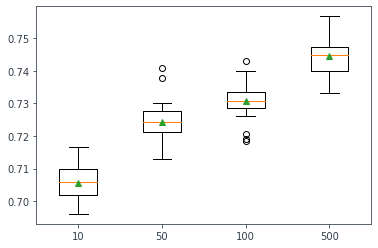

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.4.1.2- Tunning the weak learner in Ada boost - max_depth
A decision tree with one level is used as a weak learner by default in the Ada boost. We can increase the depth of the stump tree to get the optimum depth tree.

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    models = dict()
    
#     specifying the depth of trees
    for i in range(1,8):
        
        # model
        base_model = DecisionTreeClassifier(max_depth=i, random_state=7)
        
        # creating dic of modles
        models[str(i)] = AdaBoostClassifier(base_estimator=base_model, random_state=7)
        
#   returining the model -results of hyperparameter tuning of Adaboost
    return models

In this section, we will not again build the evaluation function, as we have already created in the above section. So, we can use it here as well.

In [ ]:
# calling the function
models={}
models = build_models()
# creating lists 
results, names = list(), list()
# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    accuracy = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(accuracy)
    names.append(name)
    
#     printing results of hyperparameter tuning of Adaboost
    print('---->Stump tree (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

---->Stump tree (1)---Accuracy( 0.72301)
---->Stump tree (2)---Accuracy( 0.73909)
---->Stump tree (3)---Accuracy( 0.74643)
---->Stump tree (4)---Accuracy( 0.74865)
---->Stump tree (5)---Accuracy( 0.74395)
---->Stump tree (6)---Accuracy( 0.73227)
---->Stump tree (7)---Accuracy( 0.72250)


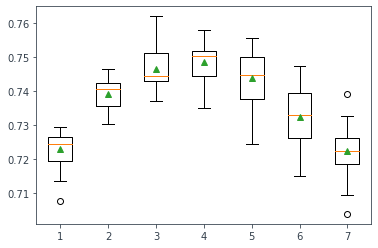

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.4.1.3- Tuning learning rate in Ada boost
Learning rate is simply the step size of each iteration. The default value of the learning rate in the Ada boost is 1. We will now use the hyperparameter tuning method to find the optimum learning rate for our model.

In [ ]:
# building the models
def build_models():
    
#     creating the model dic
    models = dict()
    
    
    # learning rate for various values
    for i in np.arange(0.1, 2.1, 0.1):
        key = '%.3f' % i
        
#         models in dic
        models[key] = AdaBoostClassifier(learning_rate=i, random_state=7)
    
#     returning models -results of hyperparameter tuning of Adaboost
    return models

In [ ]:
# calling the function
models={}
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing results of hyperparameter tuning of Adaboost
    print('---->Stump tree (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

---->Stump tree (0.100)---Accuracy( 0.69991)
---->Stump tree (0.200)---Accuracy( 0.70763)
---->Stump tree (0.300)---Accuracy( 0.71405)
---->Stump tree (0.400)---Accuracy( 0.71653)
---->Stump tree (0.500)---Accuracy( 0.71975)
---->Stump tree (0.600)---Accuracy( 0.72191)
---->Stump tree (0.700)---Accuracy( 0.72185)
---->Stump tree (0.800)---Accuracy( 0.72164)
---->Stump tree (0.900)---Accuracy( 0.72358)
---->Stump tree (1.000)---Accuracy( 0.72339)
---->Stump tree (1.100)---Accuracy( 0.72530)
---->Stump tree (1.200)---Accuracy( 0.72401)
---->Stump tree (1.300)---Accuracy( 0.72042)
---->Stump tree (1.400)---Accuracy( 0.72207)
---->Stump tree (1.500)---Accuracy( 0.72088)
---->Stump tree (1.600)---Accuracy( 0.71616)
---->Stump tree (1.700)---Accuracy( 0.71467)
---->Stump tree (1.800)---Accuracy( 0.70706)
---->Stump tree (1.900)---Accuracy( 0.69547)
---->Stump tree (2.000)---Accuracy( 0.51683)


In [ ]:
# fixing the size
plt.figure(figsize=(10, 8))
# plotting the values
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

###4.4.2- Hyper Parameter Tuning for AdaBoosting - gridSearchCV Approach
In the second aproach, we will use the GridSearchCV method to find the optimum values for the parameters of the Ada boost algorithm using the same dataset. GridSearchCV takes every possible value ( specified ones) and train the model on the different combination and returns the optimum values.

In [ ]:
# defining the classifier
model = AdaBoostClassifier()
# creating a dic for the grid
grid = dict()
# estimator till 500
grid['n_estimators'] = [100, 200, 500]
# defining learning rate
grid['learning_rate'] = [1.0, 1.1, 1.2]
# defining the CV
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
# initializing the grid search
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# training the model on grid search for hyperparameter tuning of Adaboost
grid_result = grid_search.fit(x_train, y_train)
# finding the best results /hyperparameter tuning of Adaboost
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

KeyboardInterrupt: ignored

###4.4.3- Fitting the Optimum Model

In [2134]:
dtree = DecisionTreeClassifier(criterion = 'entropy', max_depth=1, random_state=7)

In [2135]:
AdaBoost_clf = AdaBoostClassifier(base_estimator=dtree,
                                  n_estimators= 500,
                                  learning_rate=1,
                                  algorithm='SAMME.R',
                                  random_state=7)

In [2136]:
AdaBoost_model = AdaBoost_clf.fit(x_train, y_train)

In [2137]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)

In [2138]:
n_scores = cross_val_score(AdaBoost_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

KeyboardInterrupt: ignored

In [ ]:
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.745 (0.005)


In [2139]:
AdaBoost_pred = AdaBoost_model.predict(x_valid)

              precision    recall  f1-score   support

           0       0.72      0.89      0.80      3226
           1       0.51      0.10      0.17       432
           2       0.79      0.65      0.71      2282

    accuracy                           0.74      5940
   macro avg       0.67      0.55      0.56      5940
weighted avg       0.73      0.74      0.72      5940



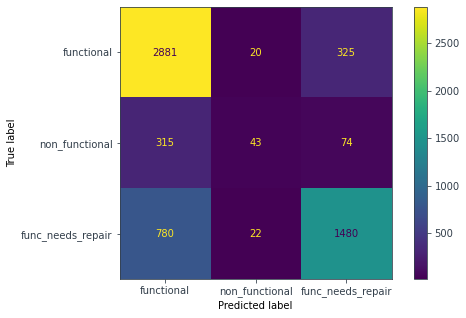

In [2140]:
print(classification_report(y_valid, AdaBoost_pred))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, AdaBoost_pred),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [ ]:
model = AdaBoostClassifier(base_estimator = RandomForestClassifier(n_estimators = 2000, random_state = 1, class_weight = class_weights)).fit(x_train,y_train)

##4.3- Gradient Boosting
Gradient Tree Boosting, Stochastic Gradient Boosting, and GBM are other names for the Gradient Boosting Algorithm. It creates a sequence of weak models ( usually decision trees) and comes up with a final strong learner. Each prediction in gradient boosting aims to outperform the one before it by lowering the errors. Gradient Boosting’s key principle is that it fits a new predictor to the residual errors created by the preceding predictor rather than fitting a prediction to the data at each iteration.

https://techfor-today.com/gradient-boosting-algorithm-using-python/



###4.3.1- Hyper Parameter Tuning for Gradient Boosting

GradientBoostingClassifier(*, loss: str = "deviance", learning_rate: float = 0.1, n_estimators: int = 100, subsample: float = 1, criterion: str = "friedman_mse", min_samples_split: int = 2, min_samples_leaf: int = 1, min_weight_fraction_leaf: float = 0, max_depth: int = 3, min_impurity_decrease: float = 0, init: Any | None = None, random_state: Any | None = None, max_features: Any | None = None, verbose: int = 0, max_leaf_nodes: Any | None = None, warm_start: bool = False, validation_fraction: float = 0.1, n_iter_no_change: Any | None = None, tol: float = 0.0001, ccp_alpha: float = 0)

####4.3.1.1- Finding the optimum number of trees in Gradient boosting

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    GB_models = dict()
    
    # number of decision stumps
    decision_stump= [150, 200, 250, 300]
        
#    using for loop to iterate though trees
    for i in decision_stump:
        
#         building model with specified trees
        GB_models[str(i)] = GradientBoostingClassifier(n_estimators=i)
    
#     returning the model
    return GB_models

In [ ]:
# function for the validation of model
def evaluate_model(model, Input, Ouput):
    
    # defining the method of validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    
    
    # validating the model based on the accurasy score
    accuracy = cross_val_score(model, Input, Ouput, scoring='accuracy', cv=cv, n_jobs=-1)
    
#     returning the accuracy score
    return accuracy

In [ ]:
# calling the build_models function
models = {}
models = build_models()
# creating list
results, names = list(), list()
# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    scores = evaluate_model(model, x_train, y_train)
    
    
    # appending the accuray socres in results
    results.append(scores)
    names.append(name)
    
    
    # printing - Gradient boosting algorithm using Python
    print('---->Iterations (%s)---Accuracy( %.5f)' % (name, np.mean(scores)))

---->Iterations (150)---Accuracy( 0.76208)


KeyboardInterrupt: ignored

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.2- Finding the optimum depth of trees in the Gradient boosting algorithm using Python

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    GB_models = dict()
    
#     specifying the depth of trees
    for i in range(1,7):
        
#         appending the models
        GB_models[str(i)] = GradientBoostingClassifier(max_depth=i)
        
#   returining the model
    return GB_models

In [ ]:
# calling the function
models = build_models()
# creating lists 
results, names = list(), list()
# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    accuracy = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(accuracy)
    names.append(name)
    
#     printing - Gradient boosting algorithm using Python
    print('---->Decision tree depth (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

NameError: ignored

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.3- Finding an optimum Learning rate in Gradient boosting algorithm using Python

In [ ]:
# creating function
def build_models():
    
#     creating dic of models
    GB_models = dict()
    
#     different learning rates
    for i in [0.05, 0.1, 0.2, 0.5, 1.0, 1.5]:
        
#         key value
        k = '%.4f' % i
    
#     appending the models
        GB_models[k] = GradientBoostingClassifier(learning_rate=i)
    return GB_models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing learning rate of Gradient boosting algorithm using Python
    print('---->Learning Rate(%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.4- Finding an optimum number of features in the Gradient boosting algorithm using Python
Each decision tree can have a different amount of attributes that are utilized to suit it. Similar to modifying the sample size, changing the number of features gives more variance to the model, which may enhance performance.

In [ ]:
# creating the function 
def build_models():
    
#     creating dic of models
    GB_models = dict()
    
    # explore features numbers from 1-4
    for i in range(1,5):
        
#         appending the models
        GB_models[str(i)] = GradientBoostingClassifier(max_features=i)
    
#     returining the models
    return GB_models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing features of Gradient boosting algorithm using Python
    print('---->Features(%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.4- Finding the optimum number of samples in the Gradient boosting algorithm using Python
You can change how many samples were used to fit each tree. This indicates that a randomly chosen portion of the training dataset is used to fit each tree. Using fewer samples introduces more variance for each tree, although it can improve the overall performance of the model. Let us now create a function that returns multiple models with different sample values.

In [ ]:
# creating the function
def build_models():
    
#     dic of models
    GB_models = dict()
    
#     exploring different sample values
    for i in np.arange(0.1, 1.1, 0.1):
        
#         key value
        k = '%.1f' % i
    
#     appending the model
        GB_models[k] = GradientBoostingClassifier(subsample=i)
    return GB_models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing sampes for Gradient boosting algorithm using Python
    print('---->Samples(%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

###4.3.2- GridSearchCV for Gradient boosting algorithm using Python

In [ ]:
# defiing the model
model = GradientBoostingClassifier()
# creating a dict of grids
grid = dict()
# values for iteration
grid['n_estimators'] = [10, 50, 100, 500]
# values for learning rate
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# values for the sampel
grid['subsample'] = [0.5, 0.7, 1.0]
# values for teh depth of tree
grid['max_depth'] = [3, 4, 5]

In [ ]:
# defining the cv
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
# applying the gridsearchcv method
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# storing the values
grid_result = grid_search.fit(x_train, y_train)
# printing the best parameters of Gradient boosting algorithm using Python
print("Accuracy score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

###4.3.3- Fitting the Optimum Mode

##4.4- eXtreme Gradient boosting
Main features:
* 1- Cross-validation at each iteration: Cross-validation is a process in which the model is tested using different portions of the dataset in each iteration. The XGBoost algorithm has an internal parameter for the cross-validation and it tests each of the weak learners using the cross-validation method.
* 2- Parallel process: XGBoost uses OpenMP for parallel processing. But unlike random forests which create trees in parallel, the XGBoost creates individual trees using a parallel process.
* 3- Regularization: In Machines, learning regularization is a technique that is commonly used to reduce the risk of overfitting. Overfitting is when the models learn too many specific patterns about the training dataset and fail to generalize on the testing dataset. So, the XGBoost uses different regularization techniques in order to make sure that the model is not overfitted and that the findings can be generalized to the testing dataset.
* 4- Missing values: One of the essential features of the XGBoost algorithm is that it can handle the missing values automatically. That means we don’t need to handle missing values in the preprocessing step.
* 5- Tree pruning: Tree pruning is the process of removing the nodes from the trees that do not contribute to the classification.

https://techfor-today.com/hyperparameter-tuning-of-xgboost-algorithm/#Finding_the_optimum_number_of_features_using_Hyperparameter_tuning_of_XGBoost

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

###4.3.1- Hyper Parameter Tuning for eXtreme Gradient Boosting
1- Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.

2- Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.

3- Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.

4- Lower the learning rate and decide the optimal parameters .

####4.3.1.1- Finding the optimum number of iterations, number of stumps

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    models = dict()
    
    # number of decision stumps
    decision_stump= [100, 150, 200, 300, 400, 500, 600, 700]
        
#    using for loop to iterate though trees
    for i in decision_stump:
        
#         building model with specified trees
        # models[str(i)] = XGBClassifier(n_estimators=i)

        models[str(i)] = XGBClassifier(max_depth = 8, # the larger the more prone to overfit, range 3-10
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2
                            n_estimators = i,#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 0, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.3,
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
                            
) 
#     returning the model
    return models

In [ ]:
# function for the validation of model
def evaluate_model(model, Input, Ouput):
    
    # defining the method of validation
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=17)
    # validating the model based on the accurasy score
    accuracy = cross_val_score(model, Input, Ouput, scoring='accuracy', cv=cv, n_jobs=-1)  
    # returning the accuracy score
    return accuracy

In [ ]:
# calling the build_models function
models = {}
models = build_models()
# creating list
results, names = list(), list()
# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    accuracy = evaluate_model(model, x_train, y_train)

    # appending the accuray socres in results
    results.append(accuracy)
    names.append(name)

    # printing -Hyperparameter tuning of XGBoost
    print('---->Iterations (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

---->Iterations (100)---Accuracy( 0.78820)
---->Iterations (150)---Accuracy( 0.79345)
---->Iterations (200)---Accuracy( 0.79665)
---->Iterations (300)---Accuracy( 0.80086)
---->Iterations (400)---Accuracy( 0.80232)
---->Iterations (500)---Accuracy( 0.80307)
---->Iterations (600)---Accuracy( 0.80393)
---->Iterations (700)---Accuracy( 0.80324)


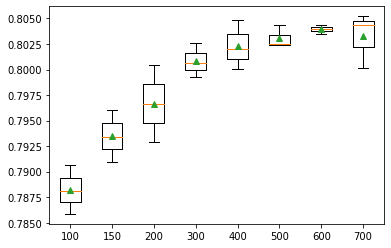

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.3- Finding the optimum sample size

In [ ]:
# creating the function
def build_models():
    
#     dic of models
    models = dict()
    
#     exploring different sample values
    for i in np.arange(0.1, 1.1, 0.1):
        
#         key value
        k = '%.1f' % i
    
#     appending the model
        models[k] = XGBClassifier(max_depth = 8, # the larger the more prone to overfit, range 3-10
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2
                            n_estimators = 600,
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 0, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = i, #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
        )
    return models

In [ ]:
# calling the function
models = {}
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():

    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing - Hyperparameter tuning of XGBoost
    print('Samples(%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

Samples(0.1)---Accuracy( 0.79175)
Samples(0.2)---Accuracy( 0.79953)
Samples(0.3)---Accuracy( 0.80181)
Samples(0.4)---Accuracy( 0.80376)
Samples(0.5)---Accuracy( 0.80479)
Samples(0.6)---Accuracy( 0.80563)
Samples(0.7)---Accuracy( 0.80410)
Samples(0.8)---Accuracy( 0.80552)
Samples(0.9)---Accuracy( 0.80597)
Samples(1.0)---Accuracy( 0.80556)


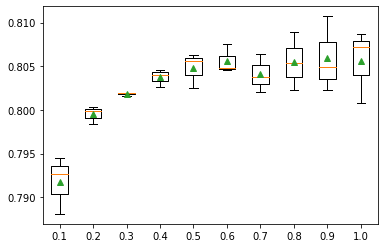

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.4- Finding optimum learning rate 

In [ ]:
# creating function
def build_models():
    
#     creating dic of models
    models = dict()
    
#     different learning rates
    for i in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        
#         key value
        k = '%.4f' % i
    
#     appending the models
        models[k] = XGBClassifier(max_depth = 8, # the larger the more prone to overfit, range 3-10
                            learning_rate = i, # range [0,1], typically=0.01-0.2 >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            n_estimators = 600,
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 0, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.6, 
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
        )
    return models

In [ ]:
# calling the function
models ={}
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing - Hyperparameter tuning of XGBoost
    print('Learning Rate(%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

Learning Rate(0.1000)---Accuracy( 0.80440)
Learning Rate(0.1500)---Accuracy( 0.80183)
Learning Rate(0.2000)---Accuracy( 0.80123)
Learning Rate(0.2500)---Accuracy( 0.80069)
Learning Rate(0.3000)---Accuracy( 0.79704)
Learning Rate(0.3500)---Accuracy( 0.79802)
Learning Rate(0.4000)---Accuracy( 0.79757)
Learning Rate(0.4500)---Accuracy( 0.79544)
Learning Rate(0.5000)---Accuracy( 0.79633)


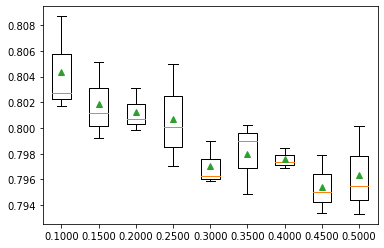

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)

# showing the plot
plt.show()

####4.3.1.5- Finding the optimum depth 

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    models = dict()
    
#     specifying the depth of trees
    for i in range(1,13):
        
#         appending the models
        models[str(i)] = XGBClassifier(max_depth = i, # the larger the more prone to overfit, range 3-10 >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2 
                            n_estimators = 600,
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 0, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.6, 
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
        )
        
#   returining the model
    return models

In [ ]:
# calling the function
models = {}
models = build_models()

# creating lists 
results, names = list(), list()

# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    accuracy = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(accuracy)
    names.append(name)
    
#     printing - Hyperparameter tuning of XGBoost
    print('Decision tree depth (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

Decision tree depth (1)---Accuracy( 0.73371)
Decision tree depth (2)---Accuracy( 0.75653)
Decision tree depth (3)---Accuracy( 0.77402)
Decision tree depth (4)---Accuracy( 0.78739)
Decision tree depth (5)---Accuracy( 0.79611)
Decision tree depth (6)---Accuracy( 0.79865)
Decision tree depth (7)---Accuracy( 0.80415)
Decision tree depth (8)---Accuracy( 0.80397)
Decision tree depth (9)---Accuracy( 0.80462)
Decision tree depth (10)---Accuracy( 0.80572)
Decision tree depth (11)---Accuracy( 0.80436)
Decision tree depth (12)---Accuracy( 0.80316)


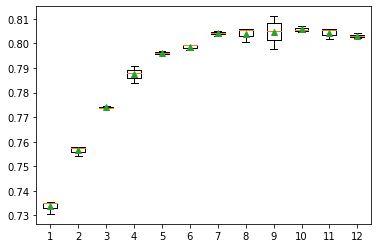

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)

# showing the plot
plt.show()

####4.3.1.6- Finding the optimum colsample_bytree

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    models = dict()
    
#     specifying the depth of trees
    for i in np.arange(0, 1.1, 0.1):
        
#         appending the models
        models[str(i)] = XGBClassifier(max_depth = 7, # the larger the more prone to overfit, range 3-10 
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2 
                            n_estimators = 600,
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 0, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.6, 
                            colsample_bytree = i, #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            colsample_bylevel = i,
                            colsample_bynode = i,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
        )
        
#   returining the model
    return models

In [ ]:
# calling the function
models = {}
models = build_models()

# creating lists 
results, names = list(), list()

# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    accuracy = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(accuracy)
    names.append(name)
    
#     printing - Hyperparameter tuning of XGBoost
    print('Portion of Features Selected - colsample_by (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

Portion of Features Selected - colsample_by (0.0)---Accuracy( 0.76839)
Portion of Features Selected - colsample_by (0.1)---Accuracy( 0.79055)
Portion of Features Selected - colsample_by (0.2)---Accuracy( 0.79611)
Portion of Features Selected - colsample_by (0.30000000000000004)---Accuracy( 0.79622)
Portion of Features Selected - colsample_by (0.4)---Accuracy( 0.80168)
Portion of Features Selected - colsample_by (0.5)---Accuracy( 0.80524)
Portion of Features Selected - colsample_by (0.6000000000000001)---Accuracy( 0.80404)
Portion of Features Selected - colsample_by (0.7000000000000001)---Accuracy( 0.80337)
Portion of Features Selected - colsample_by (0.8)---Accuracy( 0.80324)
Portion of Features Selected - colsample_by (0.9)---Accuracy( 0.80206)
Portion of Features Selected - colsample_by (1.0)---Accuracy( 0.80236)


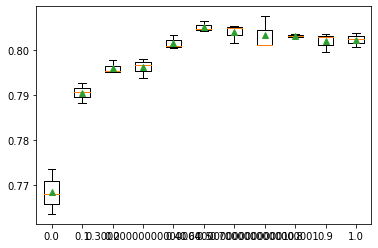

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)

# showing the plot
plt.show()

####4.3.1.7- Finding the optimum scale_pos_weight

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    models = dict()
    
#     specifying the depth of trees
    for i in np.arange(0.1, 1.1, 0.1):
        
#         appending the models
        models[str(i)] = XGBClassifier(max_depth = 7, # the larger the more prone to overfit, range 3-10 
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2 
                            n_estimators = 600,
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 1, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.6, 
                            colsample_bytree = 0.5, 
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = i, #[default=1] #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            random_state = 17,
        )
        
#   returining the model
    return models

In [ ]:
# calling the function
models = {}
models = build_models()

# creating lists 
results, names = list(), list()

# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    accuracy = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(accuracy)
    names.append(name)
    
#     printing - Hyperparameter tuning of XGBoost
    print('scale_pos_weight - colsample_by (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

scale_pos_weight - colsample_by (0.1)---Accuracy( 0.80395)
scale_pos_weight - colsample_by (0.2)---Accuracy( 0.80309)
scale_pos_weight - colsample_by (0.30000000000000004)---Accuracy( 0.80305)
scale_pos_weight - colsample_by (0.4)---Accuracy( 0.80374)
scale_pos_weight - colsample_by (0.5)---Accuracy( 0.80271)
scale_pos_weight - colsample_by (0.6)---Accuracy( 0.80397)
scale_pos_weight - colsample_by (0.7000000000000001)---Accuracy( 0.80116)
scale_pos_weight - colsample_by (0.8)---Accuracy( 0.80385)
scale_pos_weight - colsample_by (0.9)---Accuracy( 0.80370)
scale_pos_weight - colsample_by (1.0)---Accuracy( 0.80383)


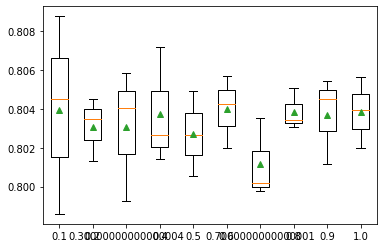

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)

# showing the plot
plt.show()

###4.3.2- GridSearchCV for Hyperparameter tuning of XGBoost

In [ ]:
# defiing the model
model = XGBClassifier( 
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            colsample_bytree = 0.5, 
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            scale_pos_weight = 0.6, #[default=1] 
                            random_state = 17,)


# creating a dict of grids
grid = dict()

# values for iteration
grid['n_estimators'] = [400, 500, 600, 700]

# values for learning rate
grid['learning_rate'] = [0.08, 0.09, 0.1]

# values for the sampel
grid['subsample'] = [0.3, 0.4, 0.5, 0.6]

# values for teh depth of tree
grid['max_depth'] = [6, 7, 8, 9]

In [ ]:
# defining the cv
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)


# applying the gridsearchcv method
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')

# storing the values
grid_result = grid_search.fit(x_train, y_train)


# printing the best parameters - Hyperparameter tuning of XGBoost
print("Accuracy score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

###f
https://kevinvecmanis.io/machine%20learning/hyperparameter%20tuning/dataviz/python/2019/05/11/XGBoost-Tuning-Visual-Guide.html

https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook

In [ ]:
    params = {'max_depth': [3, 6, 10],
              #'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
              #'subsample': np.arange(0.5, 1.0, 0.1),
              'colsample_bytree': np.arange(0.5, 1.0, 0.1),
              'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
              # 'n_estimators': [100, 250, 500, 750],
              }

In [ ]:
    xgbclf = xgb.XGBClassifier(objective="multi:softmax", tree_method='hist')
    clf = RandomizedSearchCV(estimator=xgbclf,
                             param_distributions=params,
                             scoring='accuracy',
                             n_iter=5,
                             n_jobs=4,
                             verbose=3)

In [ ]:
    clf.fit(x_train, y_train)

    best_combination = clf.best_params_
    print("Best hyperparameter combination: ", best_combination)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


KeyboardInterrupt: ignored

### Step 1: Fix learning rate and number of estimators for tuning tree-based parameters
max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.

min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.

gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.

subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.

scale_pos_weight = 1: Because of high class imbalance.

Lets take the default learning rate of 0.1 here and check the optimum number of trees using cv function of xgboost. The function defined above will do it for us.

###4.3.3 Fitting the Optimum Model

In [2113]:
xgboost_clf = XGBClassifier(max_depth = 7, # the larger the more prone to overfit, range 3-10
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2
                            n_estimators = 600,
                            verbosity = 1,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 1, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.6,
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
                            
)

In [2114]:
xgboost_clf.fit(x_train,y_train)

XGBClassifier(colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.5,
              max_depth=7, n_estimators=600, objective='multi:softprob',
              random_state=17, scale_pos_weight=0.5, subsample=0.6)

In [2115]:
xgboost_preds = xgboost_clf.predict(x_valid)

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      3226
           1       0.58      0.33      0.42       432
           2       0.85      0.77      0.81      2282

    accuracy                           0.81      5940
   macro avg       0.75      0.67      0.69      5940
weighted avg       0.81      0.81      0.80      5940



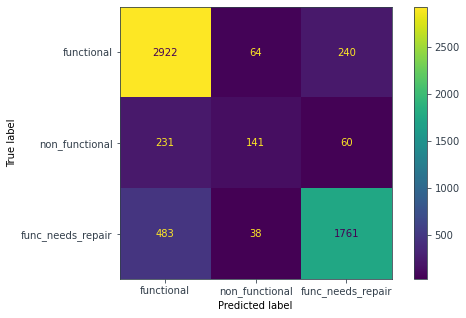

In [2116]:
print(classification_report(y_valid, xgboost_preds))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, xgboost_preds),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

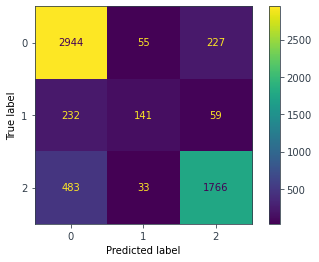

In [ ]:
# importing modules
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# <a href="https://techfor-today.com/sklearn-confusion-matrix-in-machine-learning/">confusion matrix</a> plotting
cm = confusion_matrix(y_valid,xgboost_preds, labels=xgboost_clf.classes_)
# labelling
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgboost_clf.classes_)
disp.plot()
plt.show()

In [2117]:
xgboost_feature_scores = pd.Series(xgboost_clf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

# xgboost_feature_scores

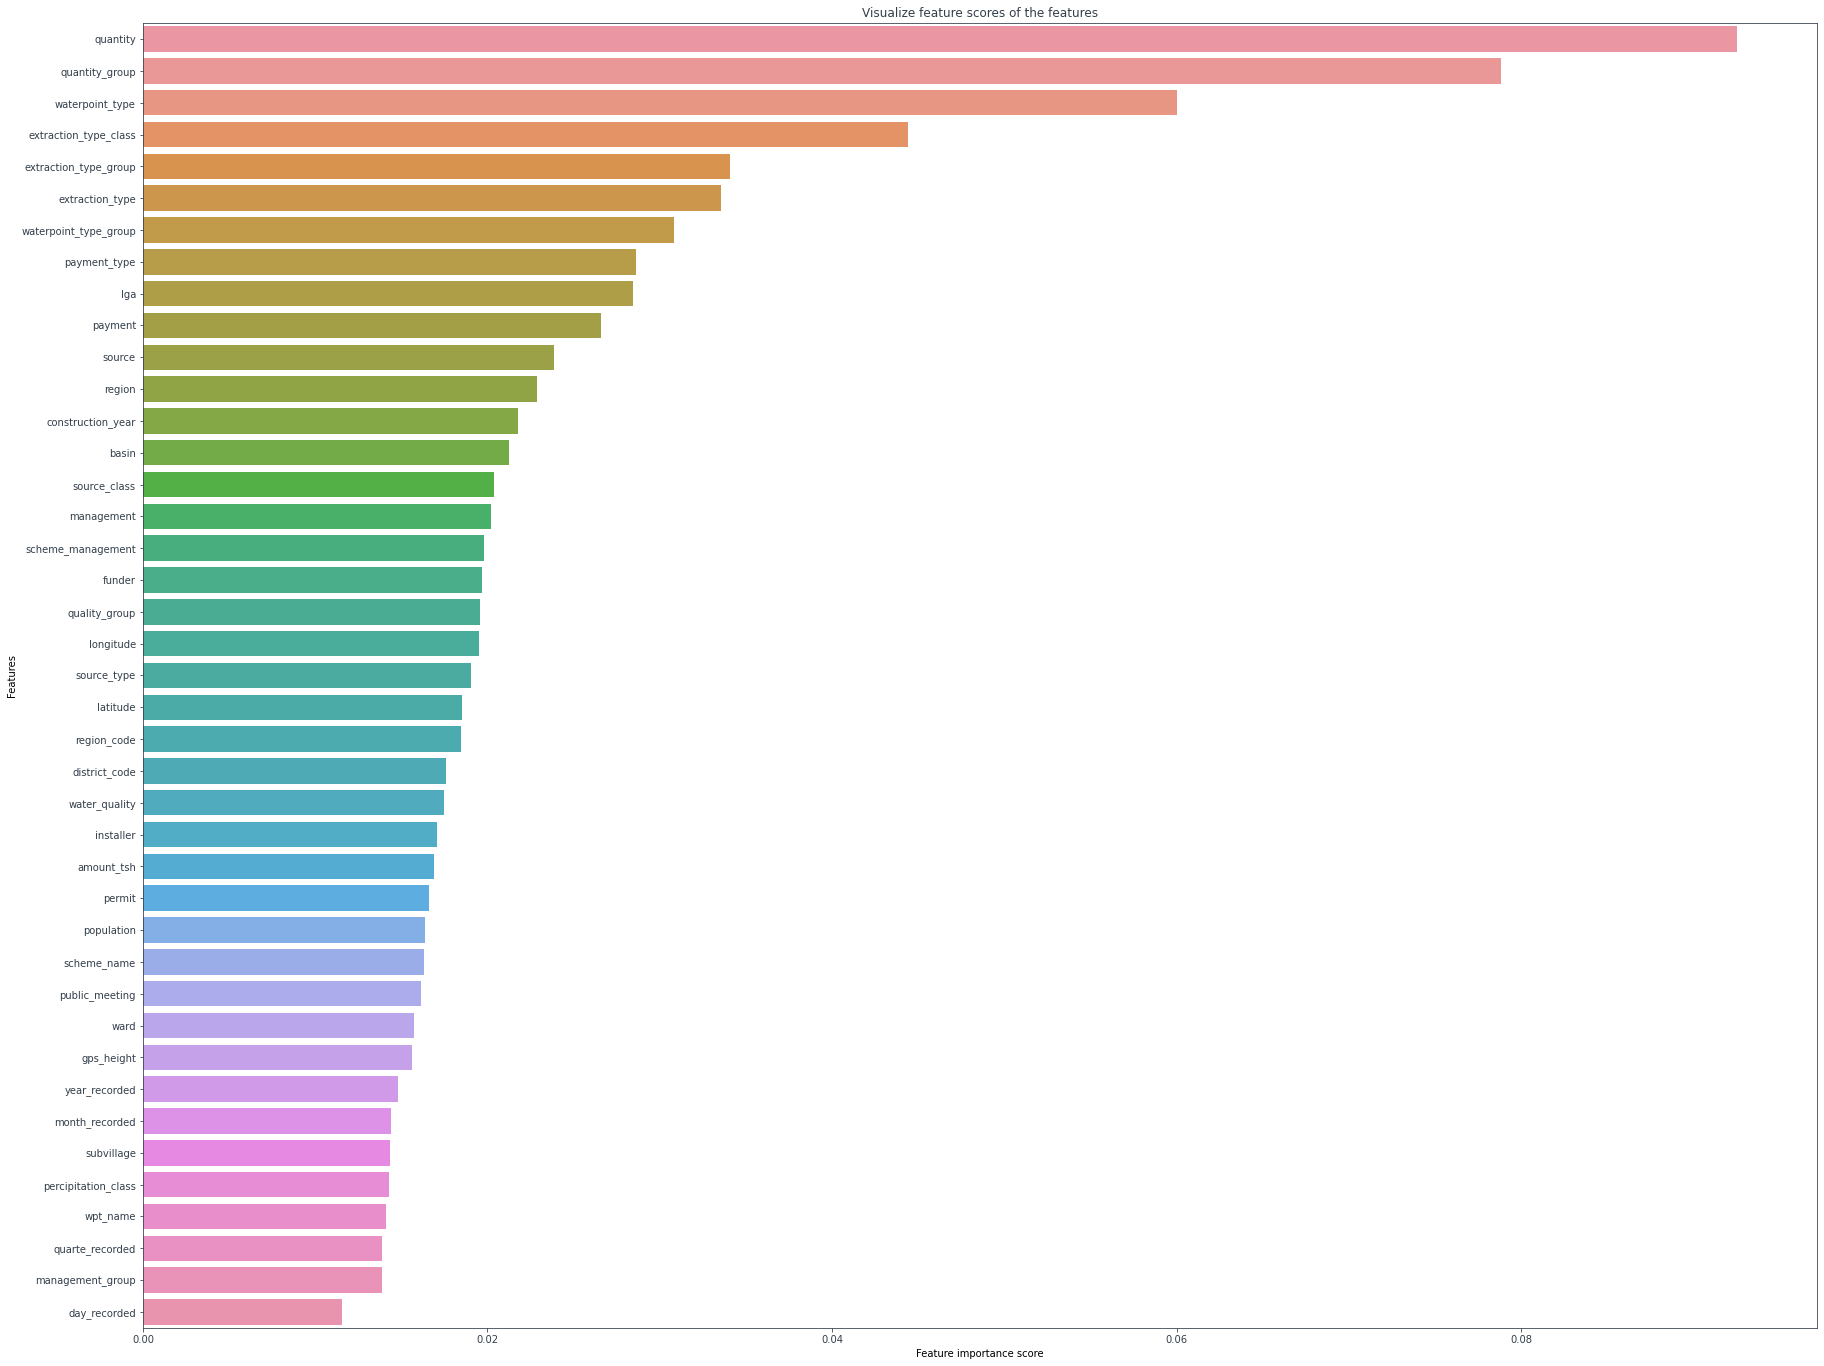

In [2118]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=xgboost_feature_scores, y=xgboost_feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(xgboost_feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

##4.4- LightGBM
Light Gradient Boosting Machine. It is a supervised boosting algorithm that works in a similar way as the XGBoost algorithm does but with some advanced features that makes it more powerful and fast.

Don’t need to handle the NULL value explicitly in the data preprocessing step while using the LightGBM algorithm as it also handles NULL values automatically.

It uses a histogram-based algorithm for the splitting of nodes and Gradient-Based One Side Sampling (GOSS) for the sampling.

###4.4.1- Hyperparameter tuning of LightGBM

####4.4.1.1- Finding the optimum number of iterations in LightGBM

In [ ]:
# function for the validation of model
def evaluate_model(model, Input, Ouput):
    
    # defining the method of validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    
    
    # validating the model based on the accurasy score
    r_square = cross_val_score(model, Input, Ouput, scoring='r2', cv=cv, n_jobs=-1)
    
#     returning the accuracy score
    return r_square

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    models = dict()
    
    # number of decision stumps
    decision_stump= [10, 50, 100, 500]
        
#    using for loop to iterate though trees
    for i in decision_stump:
        
#         building model with specified trees
        models[str(i)] = LGBMClassifier(n_estimators=i)
    
#     returning the model
    return models

In [ ]:
# calling the build_models function
models = build_models()
# creating list
results, names = list(), list()
# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    R_square = evaluate_model(model, x_train, y_train)
    
    
    # appending the accuray socres in results
    results.append(R_square)
    names.append(name)
    
    
    # printing the accuracy score
    print('Iterations (%s)---R-square( %.5f)' % (name, np.mean(R_square)))

Iterations (10)---R-square( 0.06233)
Iterations (50)---R-square( 0.21608)
Iterations (100)---R-square( 0.26569)
Iterations (500)---R-square( 0.34298)


####4.4.1.2- Finding the optimum number of Features in LightGBM

In [ ]:
# creating the function 
def build_models():
    
#     creating dic of models
    models = dict()
    
    # explore features numbers from 1-5
    for i in range(1,6):
        
#         appending the models
        models[str(i)] = LGBMClassifier(max_features=i)
    
#     returining the models
    return models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    R_square = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(R_square)
    names.append(name)
    
#     printing
    print('---->Features(%s)---R_square( %.5f)' % (name, np.mean(R_square)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.4.1.2- Finding the optimum sample size in LightGBM

In [ ]:
# creating the function
def build_models():
    
#     dic of models
    models = dict()
    
#     exploring different sample values
    for i in np.arange(0.1, 1.1, 0.1):
        
#         key value
        k = '%.1f' % i
    
#     appending the model
        models[k] = LGBMClassifier(subsample=i)
    return models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    R_square = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(R_square)
    names.append(name)
    
#     printing
    print('Samples(%s)---R_square( %.5f)' % (name, np.mean(R_square)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.4.1.3- Finding the optimum learning rate in LightGBM

In [ ]:
# creating function
def build_models():
    
#     creating dic of models
    models = dict()
    
#     different learning rates
    for i in [0.0001, 0.001, 0.01, 0.1, 1.0]:
        
#         key value
        k = '%.4f' % i
    
#     appending the models
        models[k] = LGBMClassifier(learning_rate=i)
    return models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    R_square = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(R_square)
    names.append(name)
    
#     printing
    print('Learning Rate(%s)---R Square( %.5f)' % (name, np.mean(R_square)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.4.1.4- Finding the optimum depth of tree in LightGBM

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    models = dict()
    
#     specifying the depth of trees
    for i in range(1,12):
        
#         appending the models
        models[str(i)] = LGBMClassifier(max_depth=i)
        
#   returining the model
    return models

In [ ]:
# calling the function
models = build_models()

# creating lists 
results, names = list(), list()

# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    R_square = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(R_square)
    names.append(name)
    
#     printing the results
    print('Decision tree depth (%s)---R_square( %.5f)' % (name, np.mean(R_square)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

###4.4.2 -GridSearchCV in LightGBM to get optimum values for parameters

In [ ]:
# defiing the model
model = LGBMClassifier()


# creating a dict of grids
grid = dict()

# values for iteration
grid['n_estimators'] = [10, 50, 100, 500]

# values for learning rate
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]

# values for the sampel
grid['subsample'] = [0.5, 0.7, 1.0]

# values for teh depth of tree
grid['max_depth'] = [3, 4, 5]

In [ ]:
# defining the cv
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)


# applying the gridsearchcv method
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='r2')

# storing the values
grid_result = grid_search.fit(x_train, y_train)


# printing the best parameters
print("Accuracy score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

##4.2- Random Forest 

####Fit Random Forest Model and Hyperparameter Tuning 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

In [ ]:
random_forest_hyperparam = RandomizedSearchCV(
    estimator = RandomForestClassifier(
        n_jobs = -1,
        random_state = 42,
        class_weight = 'balanced'
    ),
    param_distributions = {
        'n_estimators' : [100, 500, 1000],
    },
    scoring = 'f1',
    n_jobs = -1,
    verbose = 1,
    random_state = 42,
    return_train_score = True,
    n_iter = 25
).fit(x_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=25. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 3 candidates, totalling 15 fits


KeyboardInterrupt: ignored

In [ ]:
random_forest_hyperparam.best_params_

{'n_estimators': 100}

In [2119]:
rf_clf = RandomForestClassifier(
    n_estimators = 100,
    class_weight = 'balanced',
    random_state = 42,
    n_jobs = -1
).fit(x_train, y_train)

####Perform Prediction and Display Results for Random Forest

In [2120]:
rf_preds = rf_clf.predict(x_valid)

              precision    recall  f1-score   support

           0       0.81      0.90      0.86      3226
           1       0.56      0.35      0.43       432
           2       0.86      0.78      0.82      2282

    accuracy                           0.82      5940
   macro avg       0.75      0.68      0.70      5940
weighted avg       0.81      0.82      0.81      5940



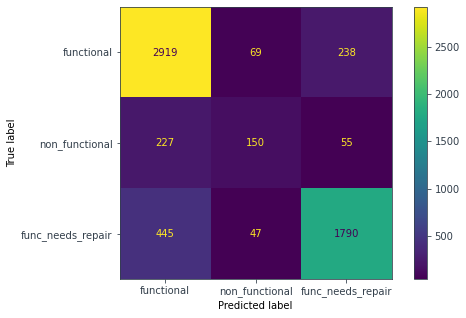

In [2121]:
print(classification_report(y_valid, rf_preds))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, rf_preds),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [2122]:
rf_table = PrettyTable()
rf_table.field_names = ['Model Name',
                  'Accuracy',
                  'F1-Score',
                  'Precision',
                  'Recall',
                  # 'Log-loss'
                 ]

rf_preds = rf_clf.predict(x_valid)

rf_table.add_row([
    'Random Forest',
    accuracy_score(y_true = y_valid, y_pred = rf_preds),
    f1_score(y_true = y_valid, y_pred = rf_preds, average='weighted'),
    precision_score(y_true = y_valid, y_pred = rf_preds, average='weighted'),
    recall_score(y_true = y_valid, y_pred = rf_preds, average='weighted'),
    # log_loss(y_true = y_valid, y_pred = rf_preds, average='weighted')
])

print(rf_table)

+---------------+-------------------+-------------------+--------------------+-------------------+
|   Model Name  |      Accuracy     |      F1-Score     |     Precision      |       Recall      |
+---------------+-------------------+-------------------+--------------------+-------------------+
| Random Forest | 0.818013468013468 | 0.811445861698057 | 0.8126130096682579 | 0.818013468013468 |
+---------------+-------------------+-------------------+--------------------+-------------------+


####Feature Importance - Random Forest

In [2123]:
feature_scores = pd.Series(rf_clf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

# feature_scores

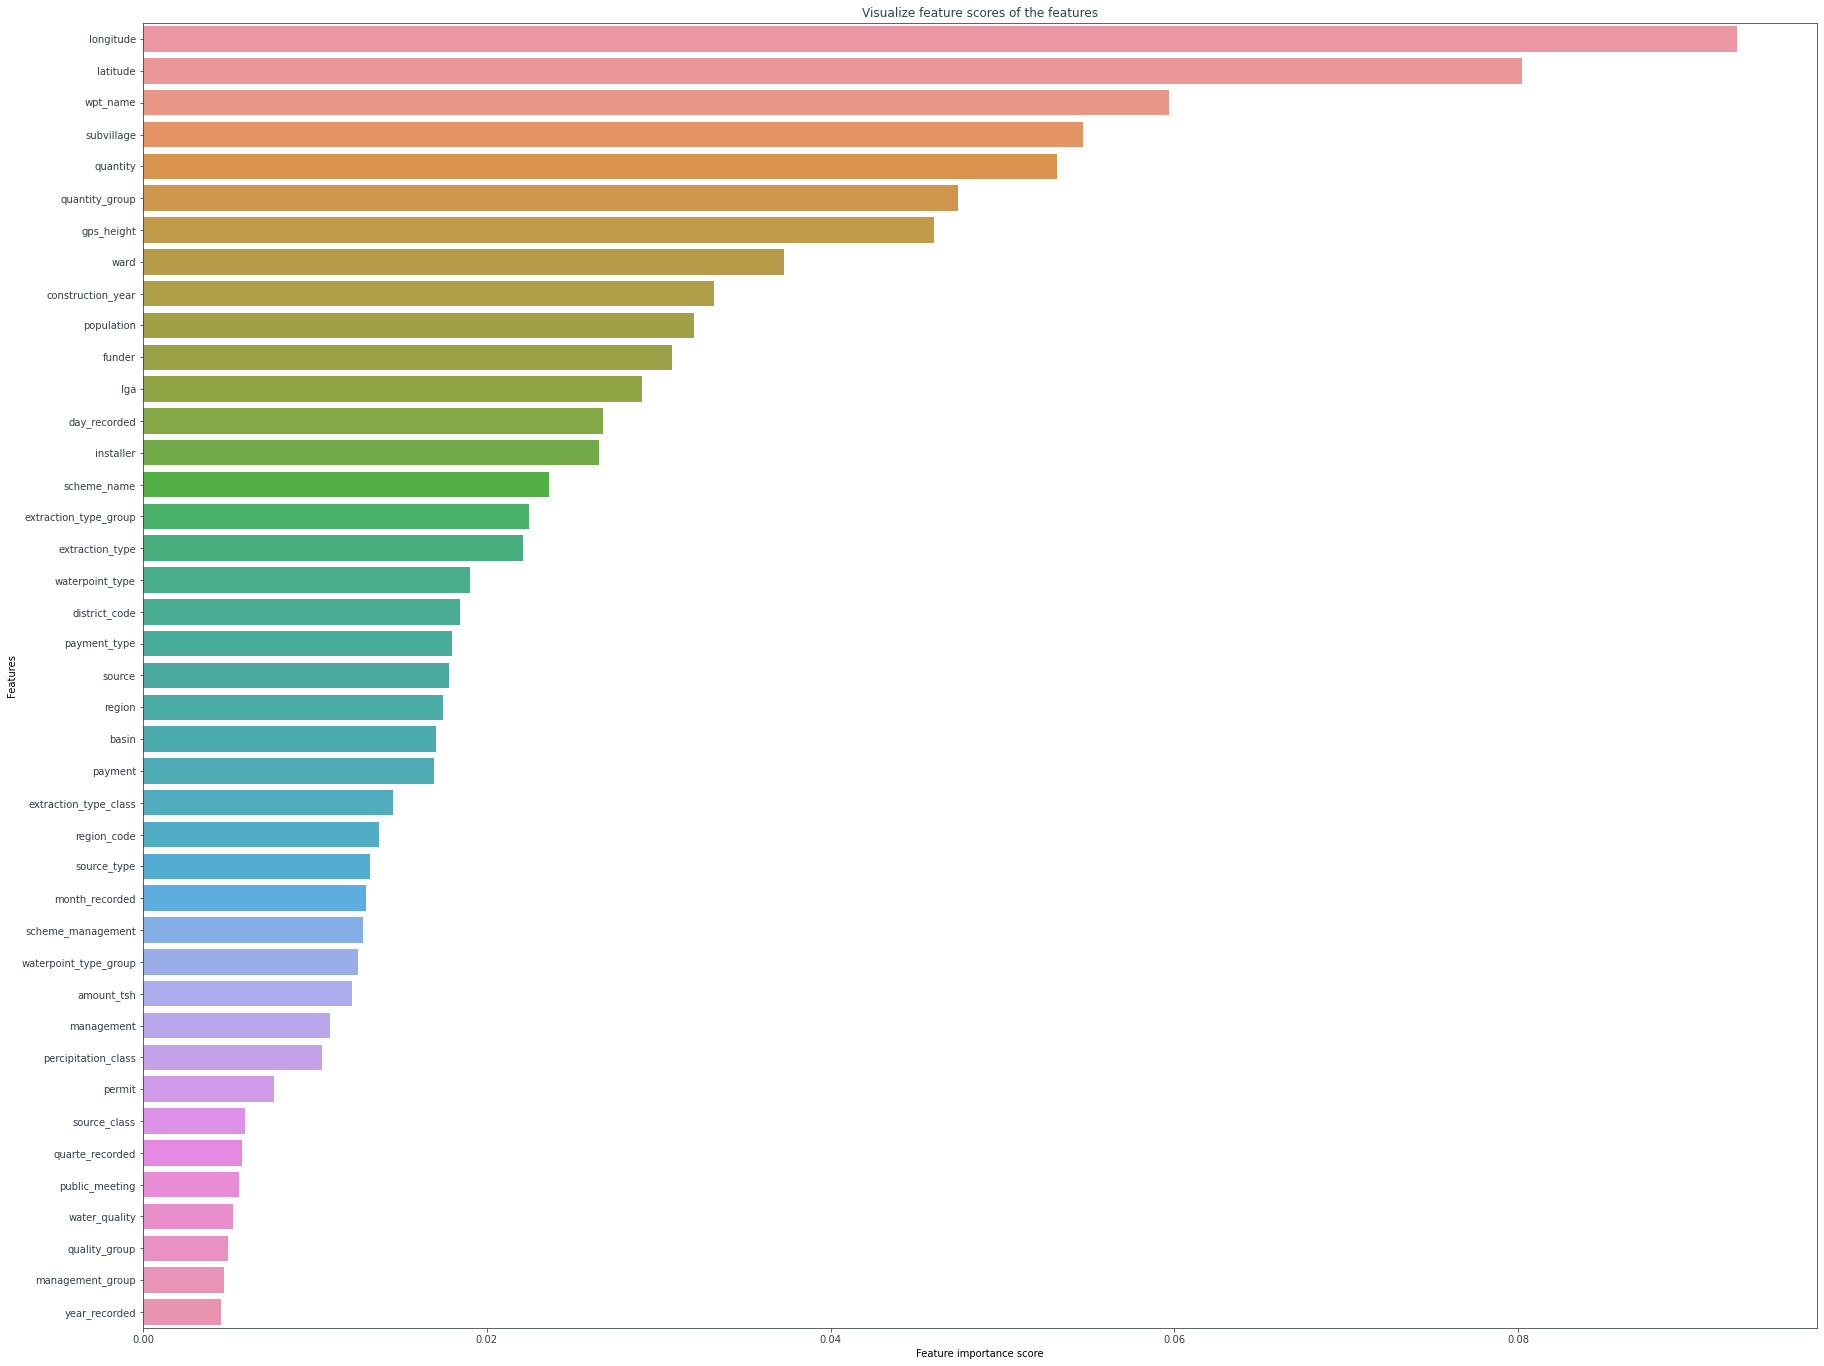

In [2124]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

##4.3-  Gradient Boosted Decision Trees

In [ ]:
gbdt_clf = XGBClassifier(
    n_estimators = 500,
    learning_rate=0.01,
    max_depth = 5,
    min_child_weight=10,
    gamma=0.4,
    nthread=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    scale_pos_weight=3,
    verbosity = 1,
    n_jobs = -1,
    random_state = 42,
).fit(x_train, y_train, verbose=1)

In [ ]:
gbdt_hyperparam = RandomizedSearchCV(
    estimator = XGBClassifier(
                learning_rate=0.01,
                max_depth = 5,
                min_child_weight=10,
                gamma=0.4,
                nthread=4,
                subsample=0.8,
                colsample_bytree=0.8,
                objective='multi:softmax',
                scale_pos_weight=3,
                verbosity = 1,
                n_jobs = -1,
                random_state = 42,
    ),
    param_distributions = [100, 500, 1000, 2000],
    n_jobs = -1,
    verbose = 3,
    random_state = 42
)

In [ ]:
gbdt_pred = gbdt_clf.predict(x_valid)

              precision    recall  f1-score   support

           0       0.71      0.94      0.81      3226
           1       0.60      0.11      0.19       432
           2       0.85      0.59      0.70      2282

    accuracy                           0.75      5940
   macro avg       0.72      0.55      0.56      5940
weighted avg       0.76      0.75      0.72      5940



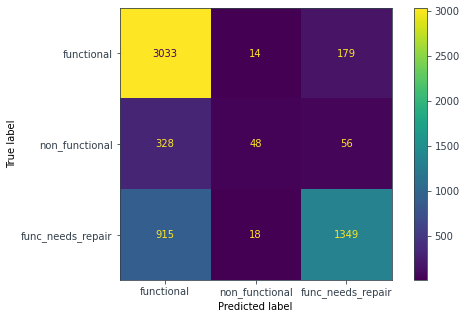

In [ ]:
print(classification_report(y_valid, gbdt_pred))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, gbdt_pred),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [ ]:
gbdt_table = PrettyTable()
gbdt_table.field_names = ['Model Name',
                  'Accuracy',
                  'F1-Score',
                  'Precision',
                  'Recall',
                  # 'Log-loss'
                 ]

gbdt_pred = gbdt_clf.predict(x_valid)

gbdt_table.add_row([
    'GBDT',
    accuracy_score(y_true = y_valid, y_pred = gbdt_pred),
    f1_score(y_true = y_valid, y_pred = gbdt_pred, average='weighted'),
    precision_score(y_true = y_valid, y_pred = gbdt_pred, average='weighted'),
    recall_score(y_true = y_valid, y_pred = gbdt_pred, average='weighted'),
    # log_loss(y_true = y_vali, y_pred = gbdt_pred, average='weighted')
])

print(gbdt_table)

+------------+--------------------+--------------------+--------------------+--------------------+
| Model Name |      Accuracy      |      F1-Score      |     Precision      |       Recall       |
+------------+--------------------+--------------------+--------------------+--------------------+
|    GBDT    | 0.7457912457912458 | 0.7208843356050798 | 0.7560391506046725 | 0.7457912457912458 |
+------------+--------------------+--------------------+--------------------+--------------------+


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


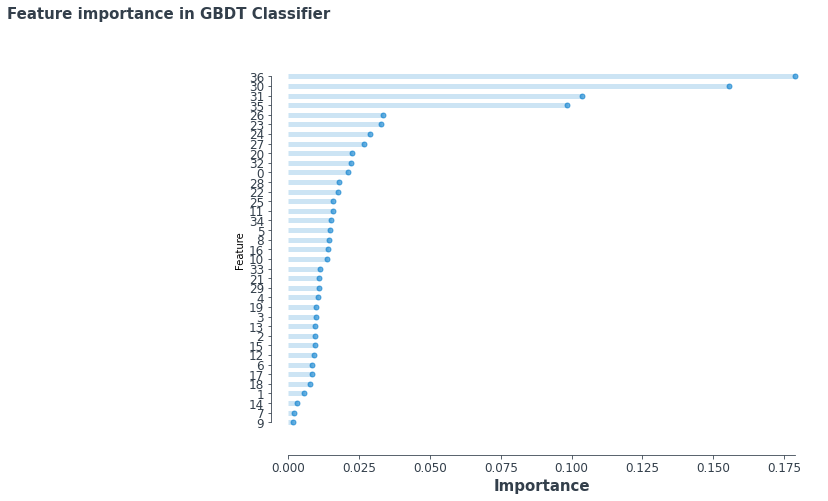

In [ ]:
#feature importances

pretty_importances_plot(
    gbdt_clf.feature_importances_, 
    [i for i in range(x_train.shape[1])],
    xlabel = 'Importance',
    ylabel = 'Feature',
    horizontal_label = 'Feature importance in GBDT Classifier'
)

##4.5- CatBoostClassifier